In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#sklearn
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV
from sklearn.inspection import permutation_importance

from sklearn.neighbors import KNeighborsClassifier

#json
import json

<h3>Functions</h3>

In [2]:
def plot_grid_search_results(grid_results, grid_best_params, grid_best_score):
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (12,18)) #figsize = (13,30)
    
    ax1.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_f1'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_f1'],
                 ecolor = 'orange')
    ax1.set_xlabel('n_neigbors')
    ax1.set_ylabel('f1')
    ax1.set_title('Classification F1')
    
    ax2.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_recall'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_recall'],
                 ecolor = 'orange')
    ax2.set_xlabel('n_neigbors') 
    ax2.set_ylabel('recall')
    ax2.set_title('Classification Recall')
    
    ax3.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_roc_auc'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_roc_auc'],
                 ecolor = 'orange')
    ax3.plot([grid_best_params['n_neighbors']], [grid_best_score], 
              marker='.', 
              markeredgewidth=3,
              c='r')
    ax3.annotate('best k', xy = (grid_best_params['n_neighbors'], grid_best_score),
                 xytext = (grid_best_params['n_neighbors'] + 1, grid_best_score + 0.02),
                 arrowprops=dict(facecolor='black', shrink=0.01))
    ax3.set_xlabel('n_neigbors') 
    ax3.set_ylabel('roc auc')
    ax3.set_title('Classification Roc Auc')

    fig.tight_layout()
    plt.show()

In [3]:
def results_permutation_importance(res, attr):
    
    # get importance
    importance = res.importances_mean
    
    # summarize feature importance
    feature_importances = []
    for col, imp in zip(attr, importance):
        feature_importances.append((col, imp))
  
    sorted_feature_importances = sorted(feature_importances, key=lambda tup:(-tup[1], tup[0]))
    
    return sorted_feature_importances

In [4]:
def plot_permutation_importance(res, attr, tit):
    
    fig, ax = plt.subplots(figsize = (12,8)) 
    
    feature_names = np.r_[attr]
    
    importance = res.importances_mean
    sorted_idx = res.importances_mean.argsort()
    
    y_ticks = np.arange(0, len(feature_names))
    ax.barh(y_ticks, importance[sorted_idx], height=0.7, color = "#CC6600")
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_title(tit)
    
    fig.tight_layout()
    plt.show()

In [5]:
def draw_confusion_matrix(Clf, X, y):
    
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(Clf, X, y,
                                 cmap='OrRd',
                                 normalize=normalize)
        disp.ax_.set_title(title)
    
    plt.show()

In [6]:
def draw_roc_curve(Y_test, Y_pred, diz, k):
    
    fig, ax = plt.subplots() #figsize = (13,30)
    
    fpr, tpr, _ = roc_curve(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred, average = None)
    
    diz[k] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc": roc_auc}
    
    ax.plot(fpr, tpr, color = "#994D00", label='ROC curve (area = %0.2f)' % (roc_auc))
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate') 
    ax.set_title('Roc curve of the model')
    ax.tick_params(axis='both')
    ax.legend(loc="lower right", fontsize=14, frameon=False)
    
    fig.tight_layout()
    plt.show()

In [7]:
df = pd.read_csv("Numerical_Encoding_Train_HR_Employee_Attrition.csv")

In [8]:
df

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,2,9,4,2,0,3,3,11,...,17,3,0,2,2,8,7,156.613636,0.387172,2.6
1,36,0,2,1,1,2,0,3,5,8,...,14,3,1,3,3,1,8,157.942308,0.411421,2.8
2,25,0,3,16,3,3,0,3,2,5,...,25,3,1,4,3,1,5,448.055556,0.704402,3.2
3,33,0,2,5,4,2,0,3,1,4,...,14,2,0,1,3,3,7,271.907692,0.841632,2.4
4,31,0,2,9,2,3,1,3,1,3,...,12,3,0,2,3,10,2,106.373333,0.207947,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,38,1,2,12,3,3,1,4,1,2,...,15,4,0,2,3,10,0,282.466667,0.789828,3.2
879,37,0,2,16,2,4,1,4,1,3,...,13,2,2,3,2,17,0,76.291667,0.711223,3.2
880,33,1,1,6,4,2,1,1,2,5,...,18,2,0,2,2,11,7,272.881579,0.751820,2.0
881,33,0,2,4,1,3,0,2,2,5,...,12,1,0,2,4,3,2,208.666667,0.862289,2.2


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       883 non-null    int64  
 1   Attrition                 883 non-null    int64  
 2   BusinessTravel            883 non-null    int64  
 3   DistanceFromHome          883 non-null    int64  
 4   Education                 883 non-null    int64  
 5   EnvironmentSatisfaction   883 non-null    int64  
 6   Gender                    883 non-null    int64  
 7   JobInvolvement            883 non-null    int64  
 8   JobLevel                  883 non-null    int64  
 9   JobRole                   883 non-null    int64  
 10  JobSatisfaction           883 non-null    int64  
 11  MonthlyIncome             883 non-null    int64  
 12  NumCompaniesWorked        883 non-null    int64  
 13  OverTime                  883 non-null    int64  
 14  PercentSal

In [10]:
df.describe()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
count,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,...,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000
mean,36.554926,0.173273,2.062288,9.201586,2.886750,2.684032,0.388448,2.750849,1.919592,4.371461,...,15.207248,2.716874,0.793884,2.665912,2.767837,6.326161,3.919592,234.245826,0.463811,2.724575
std,8.266129,0.378698,0.512402,8.241818,1.008285,1.092567,0.487674,0.729354,1.007506,2.290214,...,3.589332,1.078137,0.865362,1.187828,0.721713,4.523567,3.435392,130.196628,0.320030,0.438169
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,26.043478,0.000000,1.200000
25%,30.000000,0.000000,2.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,3.000000,...,12.000000,2.000000,0.000000,2.000000,2.000000,3.000000,2.000000,130.630208,0.129730,2.400000
50%,35.000000,0.000000,2.000000,7.000000,3.000000,3.000000,0.000000,3.000000,2.000000,4.000000,...,14.000000,3.000000,1.000000,2.000000,3.000000,5.000000,3.000000,212.279070,0.528359,2.800000
75%,42.000000,0.000000,2.000000,14.000000,4.000000,4.000000,1.000000,3.000000,2.000000,5.000000,...,18.000000,4.000000,1.000000,3.000000,3.000000,9.000000,7.000000,309.906250,0.762560,3.000000
max,60.000000,1.000000,3.000000,29.000000,5.000000,4.000000,1.000000,4.000000,5.000000,11.000000,...,25.000000,4.000000,3.000000,6.000000,4.000000,20.000000,16.000000,590.976744,0.951396,4.000000


<h3>Feature selection</h3>

In [11]:
features_sel = [col for col in df.columns if col != 'Attrition']

X_features_sel = df[features_sel].values
y_features_sel = df['Attrition']

OverTime                                           0.065304
RelationshipSatisfaction                           0.017143
StockOptionLevel                                   0.016309
JobLevel                                           0.010749
JobSatisfaction                                    0.008564
YearsAtCompany                                     0.007565
NumCompaniesWorked                                 0.006350
Age                                                0.006270
OverallSatisfaction                                0.004252
YearsInCurrentRole                                 0.003969
JobRole                                            0.003035
JobInvolvement                                     0.002913
EnvironmentSatisfaction                            0.001574
Gender                                             0.001467
TrainingTimesLastYear                              0.000413
BusinessTravel                                     0.000101
TaxRate                                 

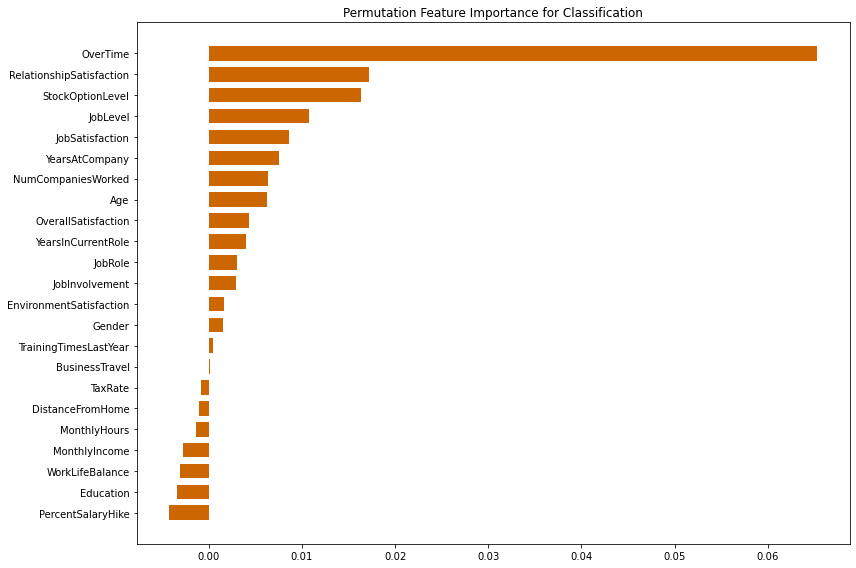

In [12]:
scaler_prova = MinMaxScaler()
X_features_sel_normalized = scaler_prova.fit_transform(X_features_sel)

model = KNeighborsClassifier()

model.fit(X_features_sel_normalized, y_features_sel)

results_features_sel = permutation_importance(model, X_features_sel_normalized, y_features_sel, scoring='roc_auc', n_repeats = 10)

sorted_feat_imp = results_permutation_importance(results_features_sel, features_sel)

#print results
for t in sorted_feat_imp:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
#plot results
t = 'Permutation Feature Importance for Classification'
plot_permutation_importance(results_features_sel, features_sel, t)

In [13]:
df = df.drop(['YearsInCurrentRole','YearsAtCompany', 'MonthlyIncome','MonthlyHours',
              'Education','Gender','BusinessTravel','PercentSalaryHike','TaxRate'], axis = 1)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       883 non-null    int64  
 1   Attrition                 883 non-null    int64  
 2   DistanceFromHome          883 non-null    int64  
 3   EnvironmentSatisfaction   883 non-null    int64  
 4   JobInvolvement            883 non-null    int64  
 5   JobLevel                  883 non-null    int64  
 6   JobRole                   883 non-null    int64  
 7   JobSatisfaction           883 non-null    int64  
 8   NumCompaniesWorked        883 non-null    int64  
 9   OverTime                  883 non-null    int64  
 10  RelationshipSatisfaction  883 non-null    int64  
 11  StockOptionLevel          883 non-null    int64  
 12  TrainingTimesLastYear     883 non-null    int64  
 13  WorkLifeBalance           883 non-null    int64  
 14  OverallSat

In [15]:
df.head()

,Age,Attrition,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole,JobSatisfaction,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,OverallSatisfaction
0,52,0,9,2,3,3,11,3,9,0,3,0,2,2,2.6
1,36,0,1,2,3,5,8,3,1,1,3,1,3,3,2.8
2,25,0,16,3,3,2,5,4,1,1,3,1,4,3,3.2
3,33,0,5,2,3,1,4,2,2,0,2,0,1,3,2.4
4,31,0,9,3,3,1,3,4,1,0,3,0,2,3,3.2


<h3>Divide into features and target</h3>

In [16]:
attributes = [col for col in df.columns if col != 'Attrition']

X = df[attributes].values
y = df['Attrition']

<h3>Stratified Holdout combined with Stratified K-fold Cross Validation</h3>

In [17]:
scaler_dict = dict()

<h4>MinMaxScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.5978492040468506
Best parameters: {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=3)

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


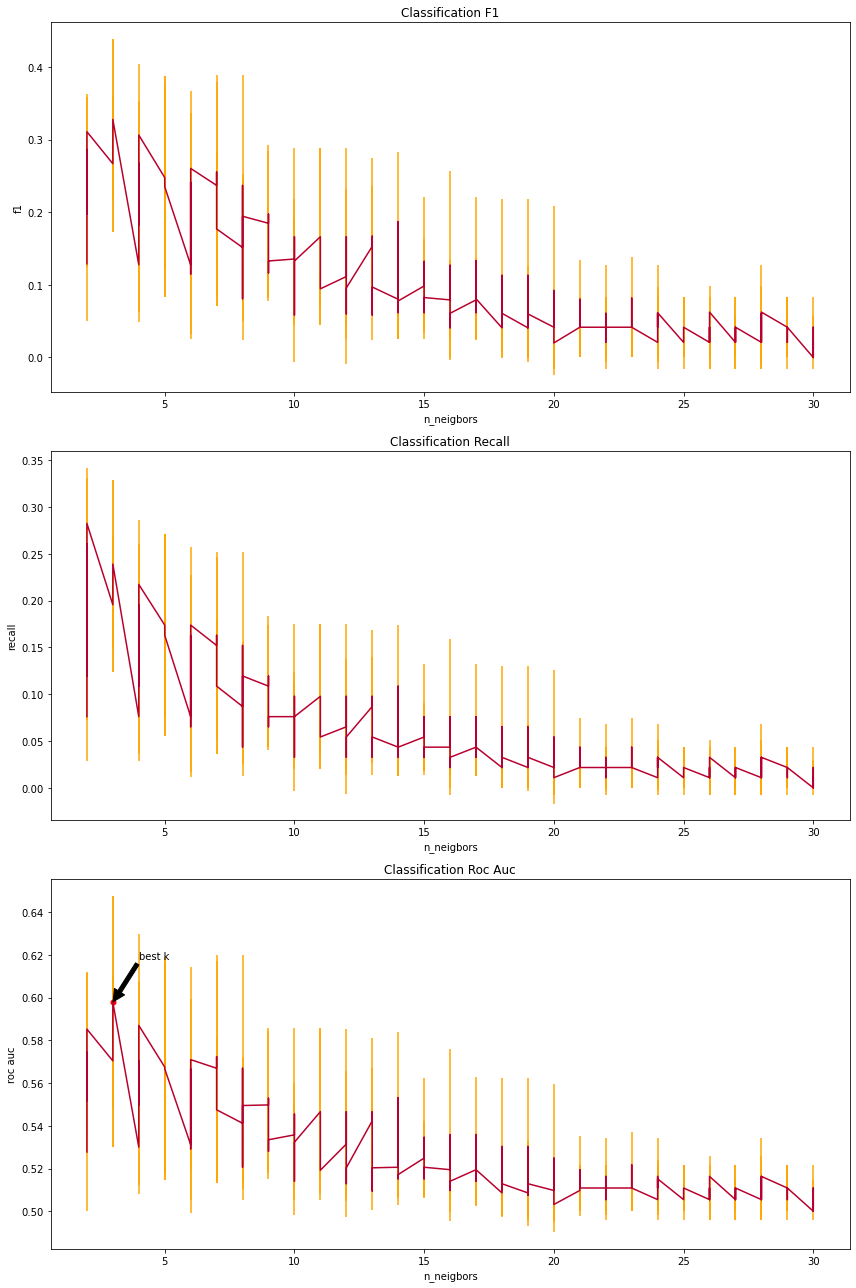



Permutation importances of the training set

OverTime                                           0.187997
RelationshipSatisfaction                           0.075062
EnvironmentSatisfaction                            0.057453
JobSatisfaction                                    0.049541
StockOptionLevel                                   0.045762
DistanceFromHome                                   0.037949
WorkLifeBalance                                    0.025379
JobInvolvement                                     0.016528
JobLevel                                           0.015042
JobRole                                            0.009495
Age                                                0.008956
NumCompaniesWorked                                 0.008341
OverallSatisfaction                                0.004587
TrainingTimesLastYear                              0.000878



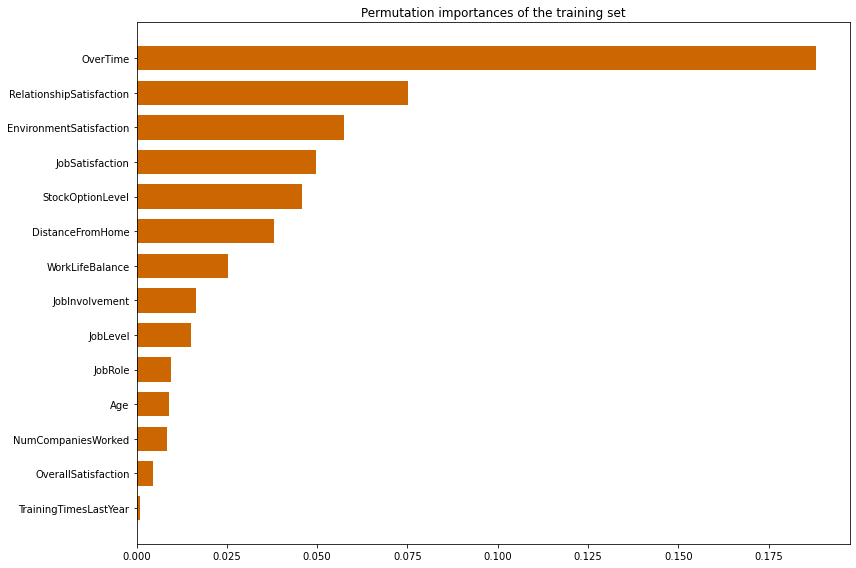



Predictions

Permutation importances of the test set

JobSatisfaction                                    0.048240
EnvironmentSatisfaction                            0.036787
StockOptionLevel                                   0.032446
OverTime                                           0.032322
Age                                                0.028859
RelationshipSatisfaction                           0.028137
JobRole                                            0.018167
JobLevel                                           0.017353
OverallSatisfaction                                0.015448
DistanceFromHome                                   0.010272
JobInvolvement                                     0.006633
WorkLifeBalance                                    0.005989
NumCompaniesWorked                                 0.003617
TrainingTimesLastYear                              -0.001709



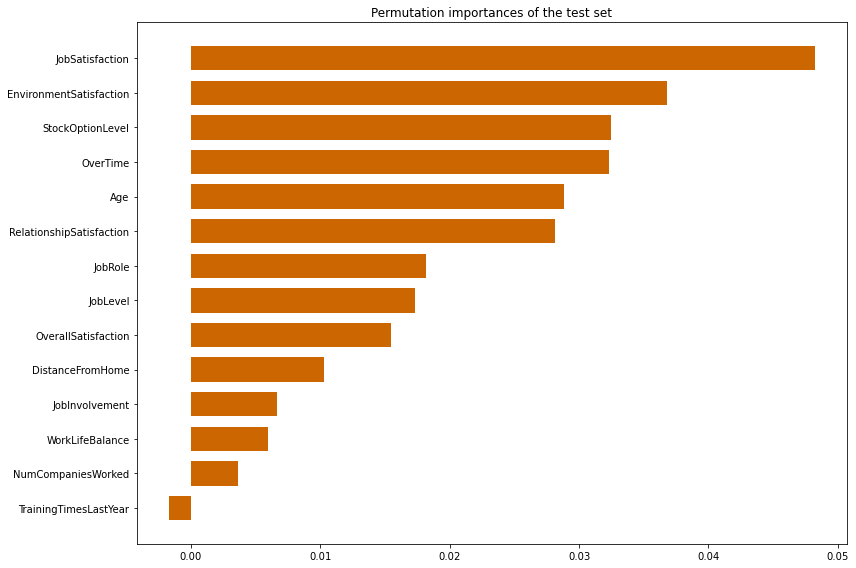



Confusion matrix


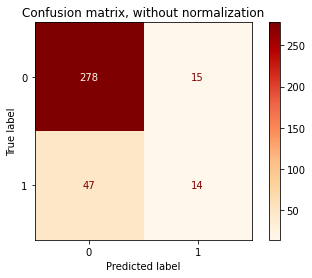

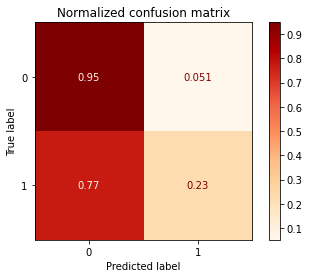


Classification report
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       293
           1       0.48      0.23      0.31        61

    accuracy                           0.82       354
   macro avg       0.67      0.59      0.61       354
weighted avg       0.79      0.82      0.80       354


Metrics

Accuracy 0.8248587570621468
F1-score [0.89967638 0.31111111]
Precision [0.85538462 0.48275862]
Recall [0.94880546 0.2295082 ]
Roc_auc 0.5891568287360823


Roc curve



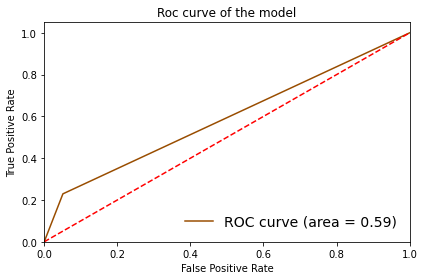


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5957252294835341
Best parameters: {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=6, p=1, weights='distance')

Best k ('n_neighbors'): 6

Plots of the metrics used by the grid search


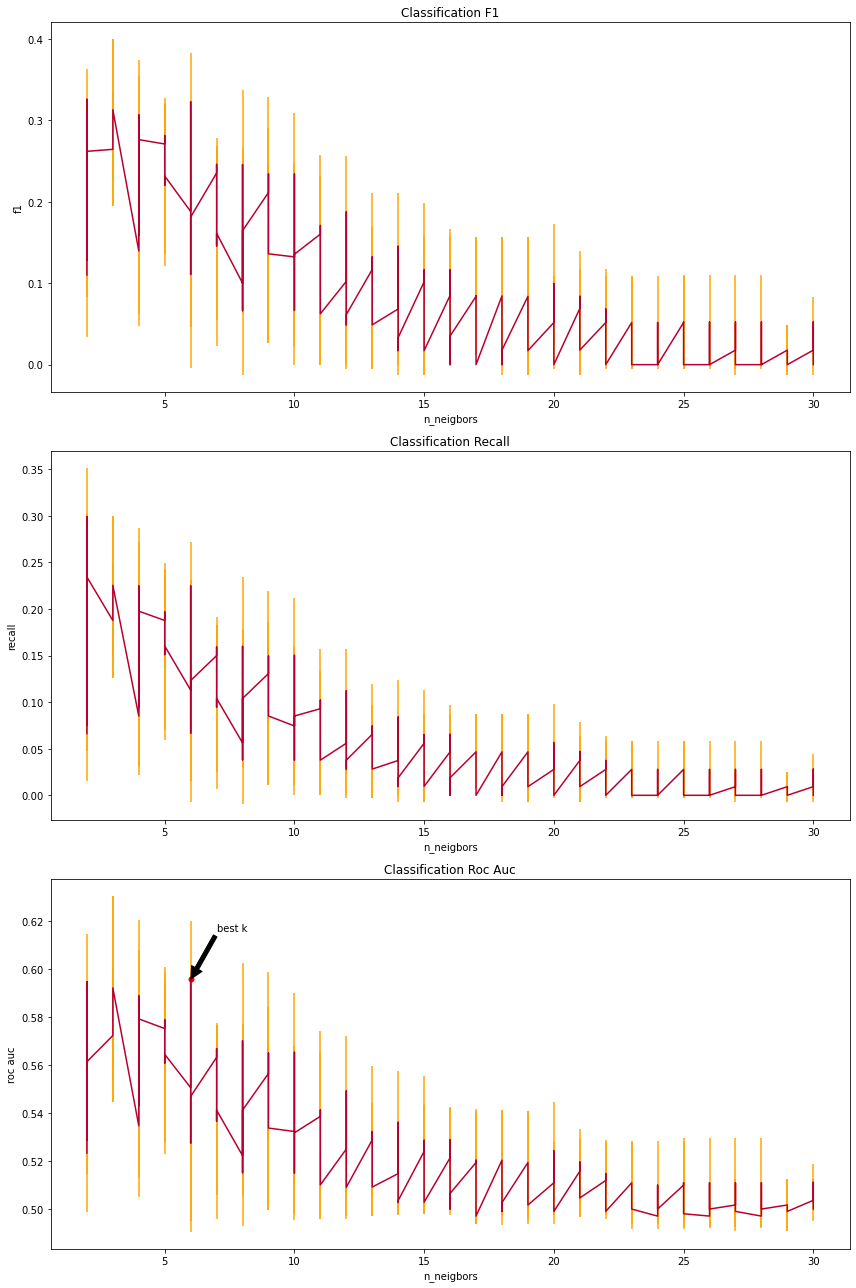



Permutation importances of the training set

OverTime                                           0.021504
RelationshipSatisfaction                           0.006275
EnvironmentSatisfaction                            0.004186
JobSatisfaction                                    0.004095
StockOptionLevel                                   0.002699
DistanceFromHome                                   0.002231
NumCompaniesWorked                                 0.001008
WorkLifeBalance                                    0.000722
JobInvolvement                                     0.000594
JobLevel                                           0.000461
Age                                                0.000307
JobRole                                            0.000097
OverallSatisfaction                                0.000071
TrainingTimesLastYear                              0.000062



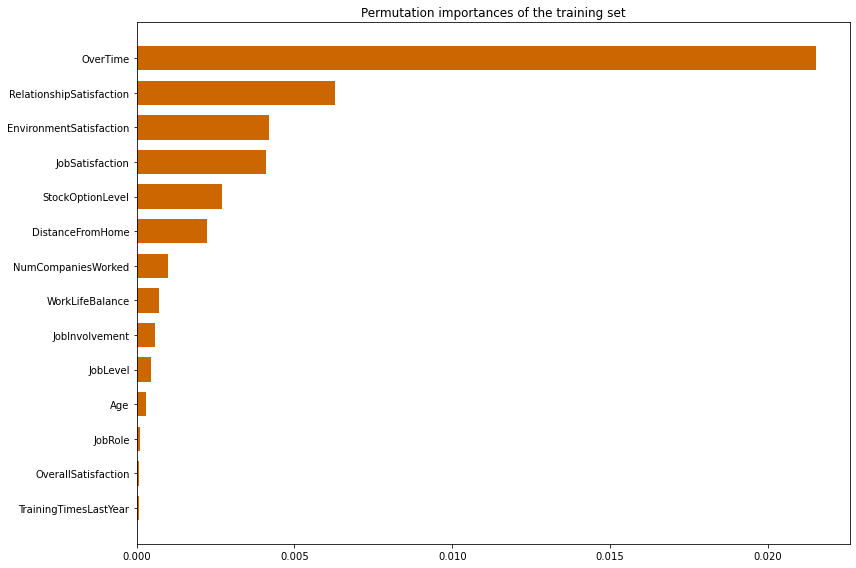



Predictions

Permutation importances of the test set

OverTime                                           0.068478
StockOptionLevel                                   0.052765
JobSatisfaction                                    0.050586
JobLevel                                           0.041979
NumCompaniesWorked                                 0.019109
Age                                                0.017788
EnvironmentSatisfaction                            0.017352
WorkLifeBalance                                    0.016607
DistanceFromHome                                   0.016428
JobInvolvement                                     0.011172
OverallSatisfaction                                0.010175
RelationshipSatisfaction                           0.009634
JobRole                                            -0.011381
TrainingTimesLastYear                              -0.013689



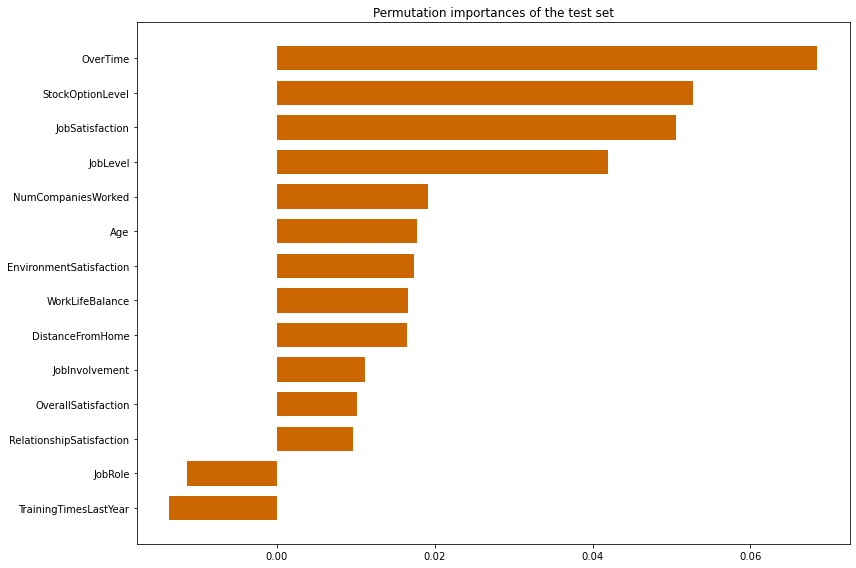



Confusion matrix


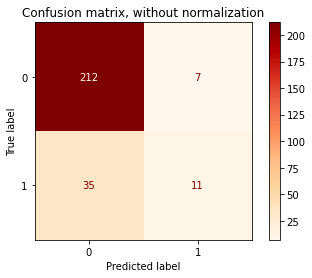

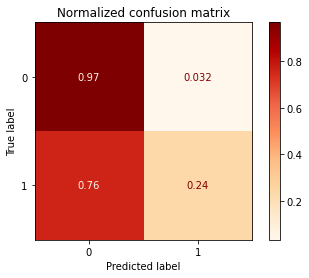


Classification report
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       219
           1       0.61      0.24      0.34        46

    accuracy                           0.84       265
   macro avg       0.73      0.60      0.63       265
weighted avg       0.82      0.84      0.81       265


Metrics

Accuracy 0.8415094339622642
F1-score [0.90987124 0.34375   ]
Precision [0.8582996  0.61111111]
Recall [0.96803653 0.23913043]
Roc_auc 0.603583482231487


Roc curve



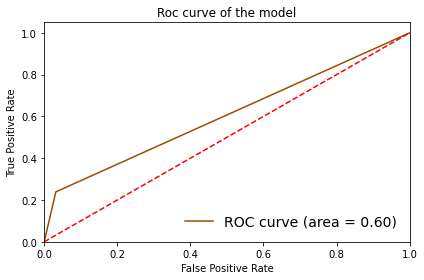


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6539217852408308
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


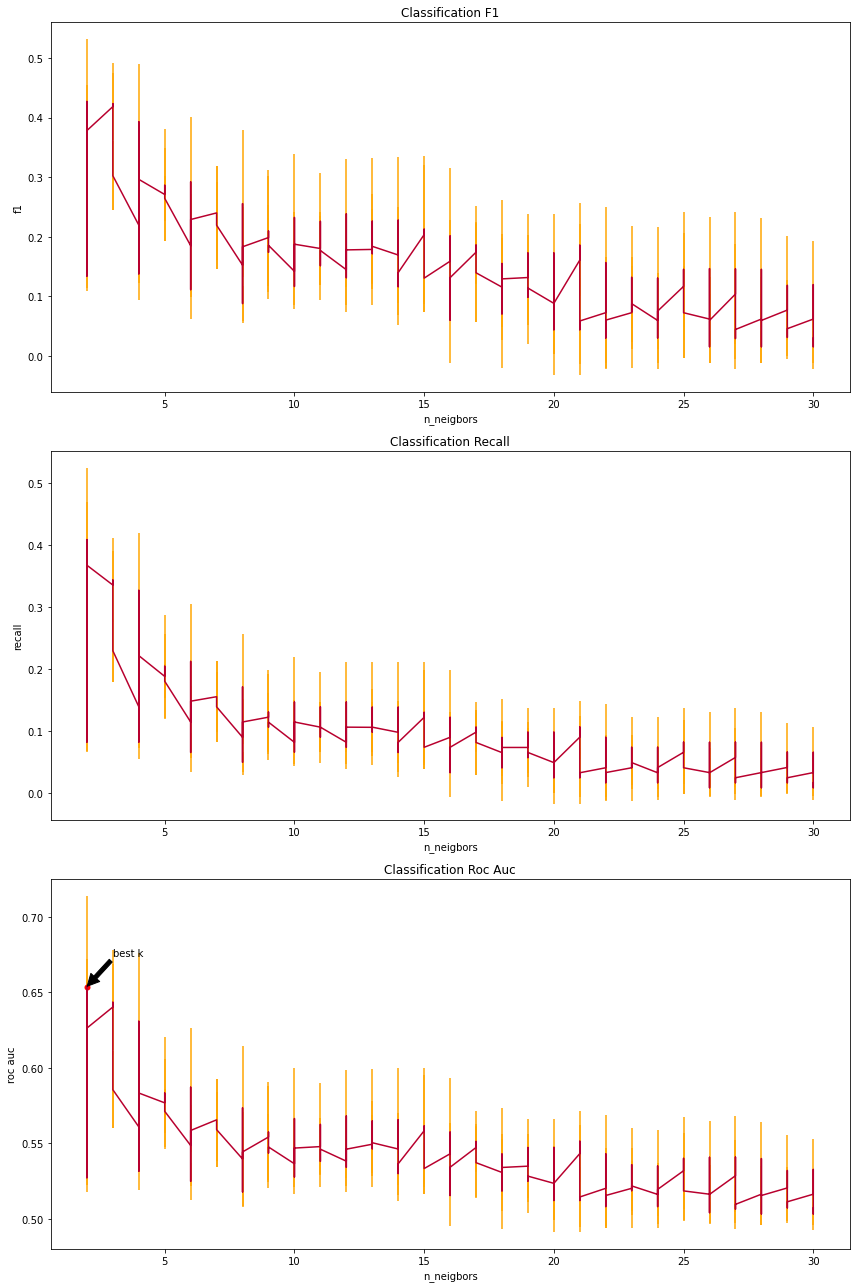



Permutation importances of the training set

OverTime                                           0.034166
RelationshipSatisfaction                           0.002456
DistanceFromHome                                   0.002266
JobSatisfaction                                    0.001592
StockOptionLevel                                   0.000903
EnvironmentSatisfaction                            0.000335
NumCompaniesWorked                                 0.000001
Age                                                0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
OverallSatisfaction                                0.000000
TrainingTimesLastYear                              0.000000
WorkLifeBalance                                    0.000000



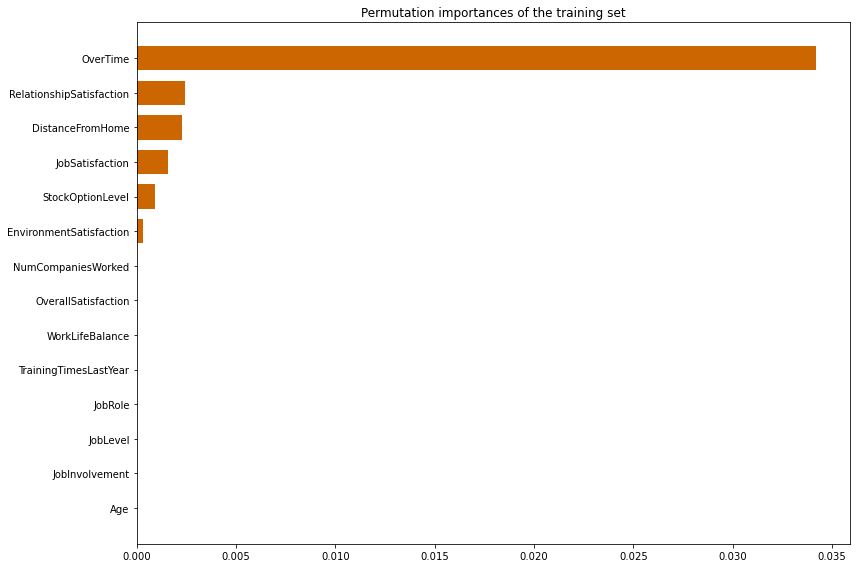



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.055380
JobSatisfaction                                    0.029065
JobLevel                                           0.026480
JobRole                                            0.012329
OverallSatisfaction                                0.005457
WorkLifeBalance                                    0.004087
JobInvolvement                                     0.002276
Age                                                -0.003182
NumCompaniesWorked                                 -0.015963
OverTime                                           -0.016726
DistanceFromHome                                   -0.022039
TrainingTimesLastYear                              -0.023674
RelationshipSatisfaction                           -0.031430
EnvironmentSatisfaction                            -0.040753



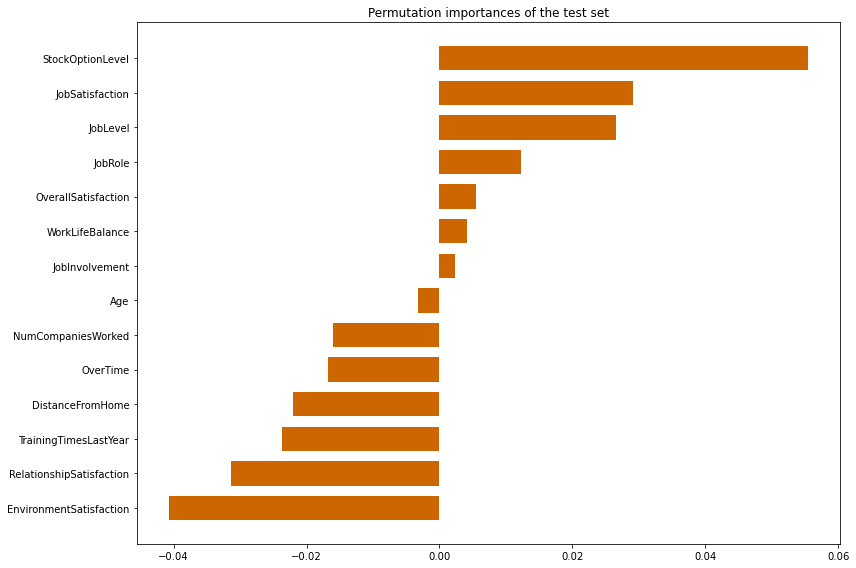



Confusion matrix


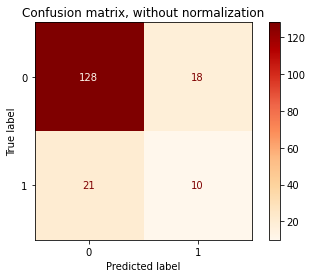

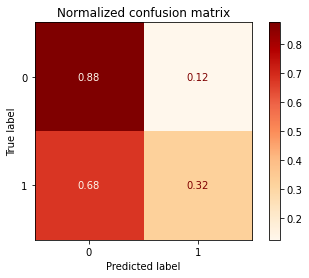


Classification report
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       146
           1       0.36      0.32      0.34        31

    accuracy                           0.78       177
   macro avg       0.61      0.60      0.60       177
weighted avg       0.77      0.78      0.78       177


Metrics

Accuracy 0.7796610169491526
F1-score [0.86779661 0.33898305]
Precision [0.8590604  0.35714286]
Recall [0.87671233 0.32258065]
Roc_auc 0.5996464869642067


Roc curve



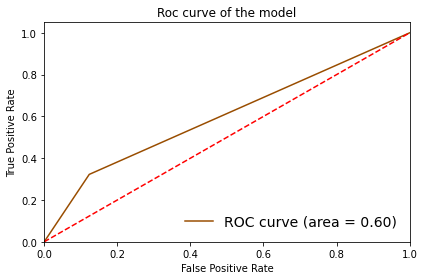


-------------------------------------------------------------------------------------------------------------



In [18]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
min_max_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MinMaxScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, min_max_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = min_max_dict

<h4>MaxAbsScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6095455452007108
Best parameters: {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=3)

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


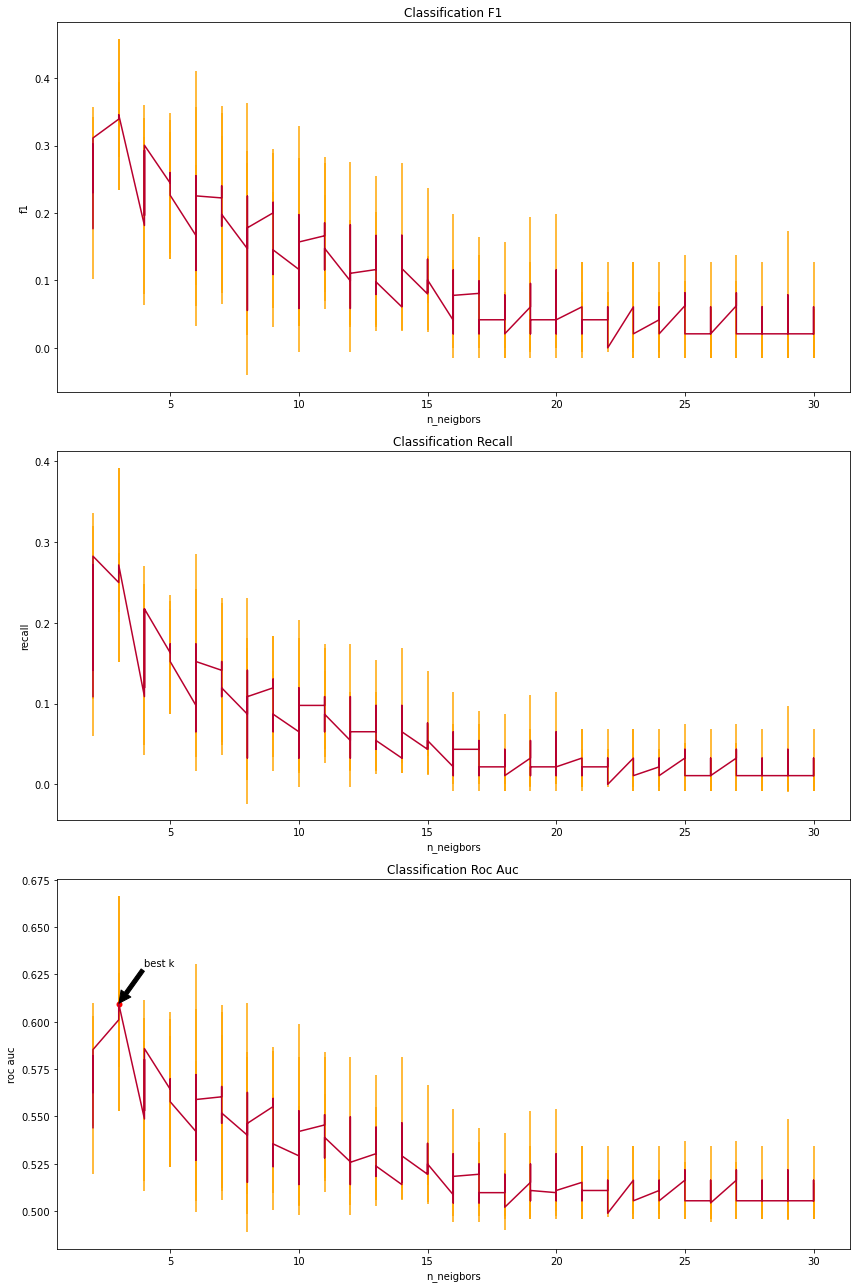



Permutation importances of the training set

OverTime                                           0.183095
RelationshipSatisfaction                           0.065942
DistanceFromHome                                   0.057514
StockOptionLevel                                   0.055579
JobSatisfaction                                    0.048238
EnvironmentSatisfaction                            0.038027
NumCompaniesWorked                                 0.022173
JobLevel                                           0.015522
JobRole                                            0.012434
WorkLifeBalance                                    0.011850
JobInvolvement                                     0.004282
TrainingTimesLastYear                              0.002035
OverallSatisfaction                                0.000690
Age                                                0.000686



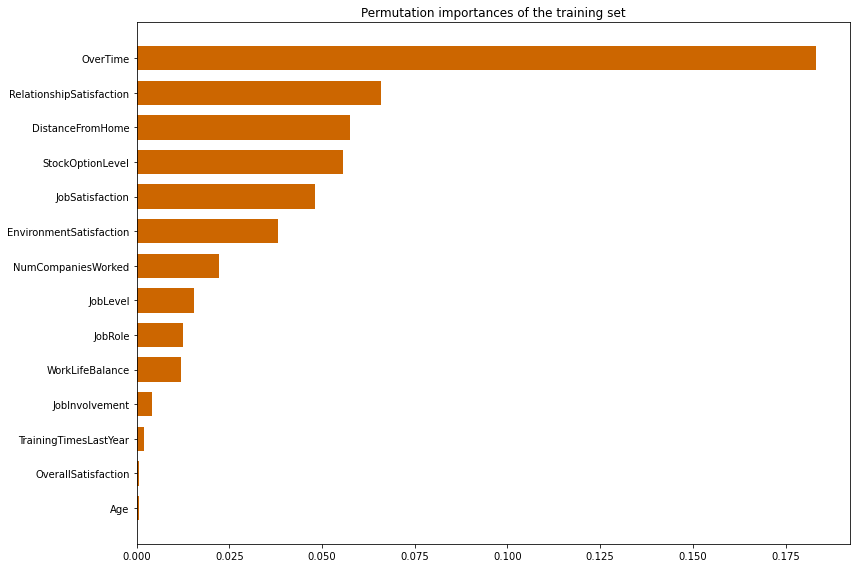



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.049049
EnvironmentSatisfaction                            0.044117
JobSatisfaction                                    0.040276
OverTime                                           0.035492
JobLevel                                           0.022028
WorkLifeBalance                                    0.019482
NumCompaniesWorked                                 0.011954
RelationshipSatisfaction                           0.011945
JobRole                                            0.010194
JobInvolvement                                     0.009039
OverallSatisfaction                                0.005796
DistanceFromHome                                   -0.002814
Age                                                -0.005307
TrainingTimesLastYear                              -0.008205



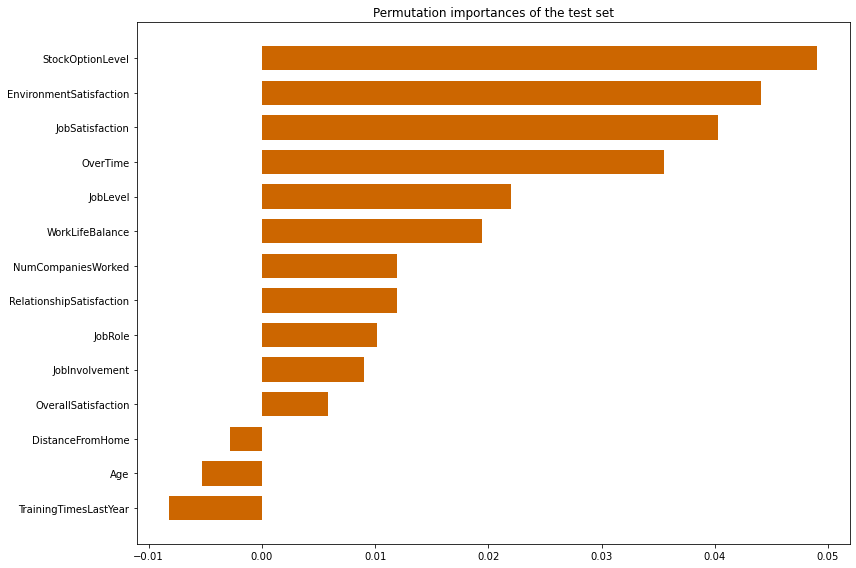



Confusion matrix


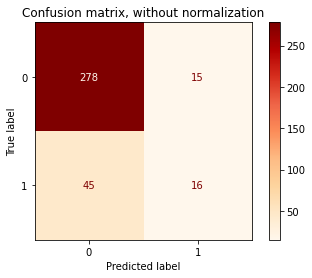

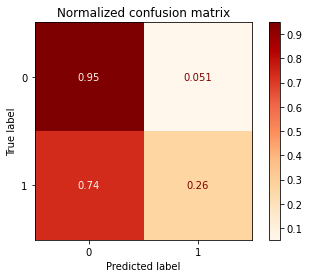


Classification report
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       293
           1       0.52      0.26      0.35        61

    accuracy                           0.83       354
   macro avg       0.69      0.61      0.63       354
weighted avg       0.80      0.83      0.81       354


Metrics

Accuracy 0.8305084745762712
F1-score [0.9025974  0.34782609]
Precision [0.86068111 0.51612903]
Recall [0.94880546 0.26229508]
Roc_auc 0.6055502713590333


Roc curve



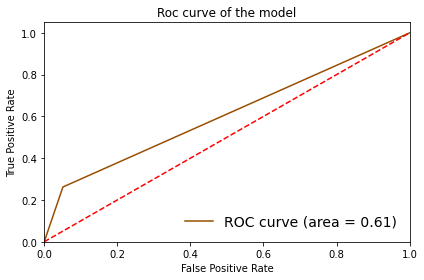


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.6016365029191062
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


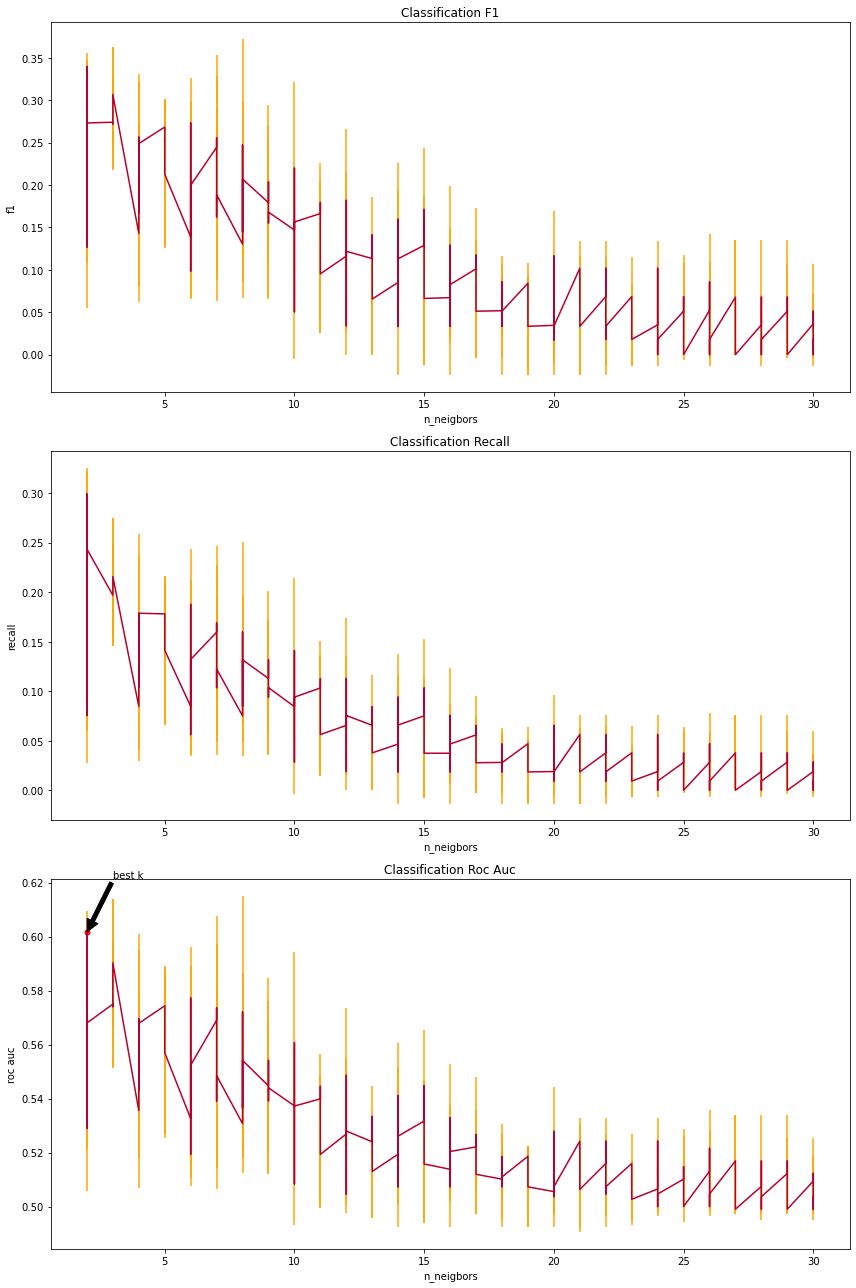



Permutation importances of the training set

OverTime                                           0.025551
NumCompaniesWorked                                 0.004098
JobSatisfaction                                    0.001580
RelationshipSatisfaction                           0.000558
StockOptionLevel                                   0.000287
DistanceFromHome                                   0.000042
EnvironmentSatisfaction                            0.000002
Age                                                0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
OverallSatisfaction                                0.000000
TrainingTimesLastYear                              0.000000
WorkLifeBalance                                    0.000000



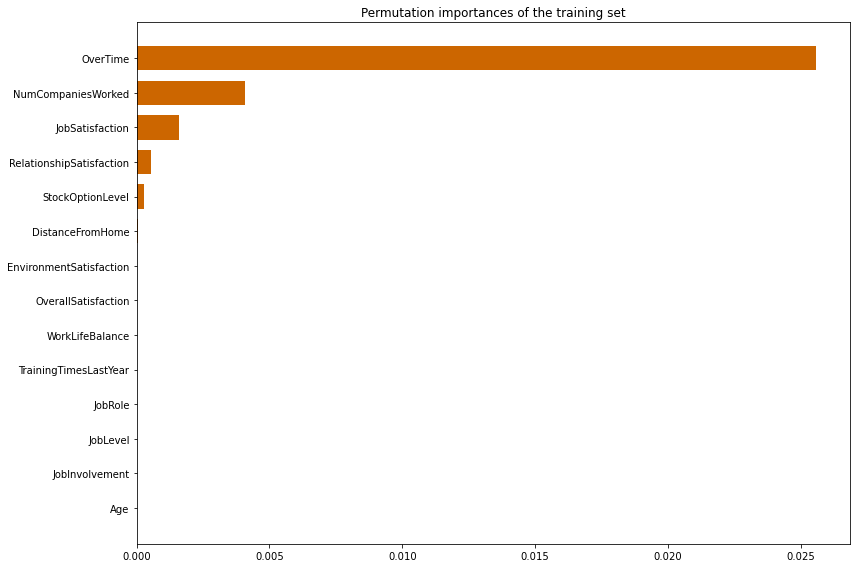



Predictions

Permutation importances of the test set

OverTime                                           0.067084
JobSatisfaction                                    0.065783
StockOptionLevel                                   0.052680
RelationshipSatisfaction                           0.032638
Age                                                0.032599
JobRole                                            0.027090
JobLevel                                           0.025447
NumCompaniesWorked                                 0.020186
OverallSatisfaction                                0.018672
WorkLifeBalance                                    0.018111
JobInvolvement                                     0.005698
EnvironmentSatisfaction                            -0.004904
TrainingTimesLastYear                              -0.019754
DistanceFromHome                                   -0.023451



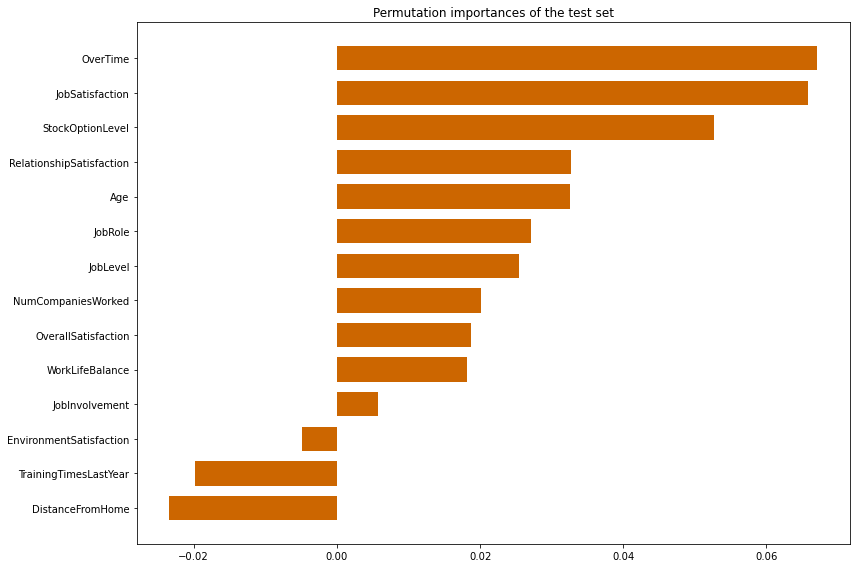



Confusion matrix


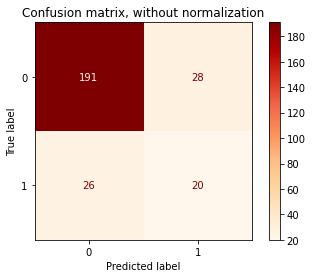

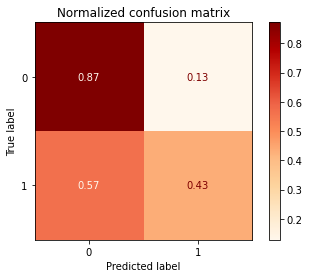


Classification report
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       219
           1       0.42      0.43      0.43        46

    accuracy                           0.80       265
   macro avg       0.65      0.65      0.65       265
weighted avg       0.80      0.80      0.80       265


Metrics

Accuracy 0.7962264150943397
F1-score [0.87614679 0.42553191]
Precision [0.88018433 0.41666667]
Recall [0.87214612 0.43478261]
Roc_auc 0.6534643637085567


Roc curve



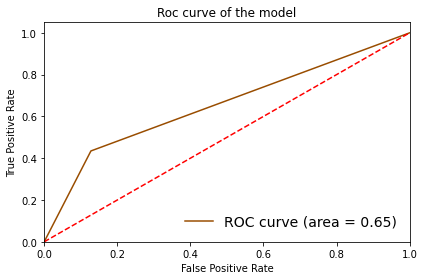


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6602739726027397
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


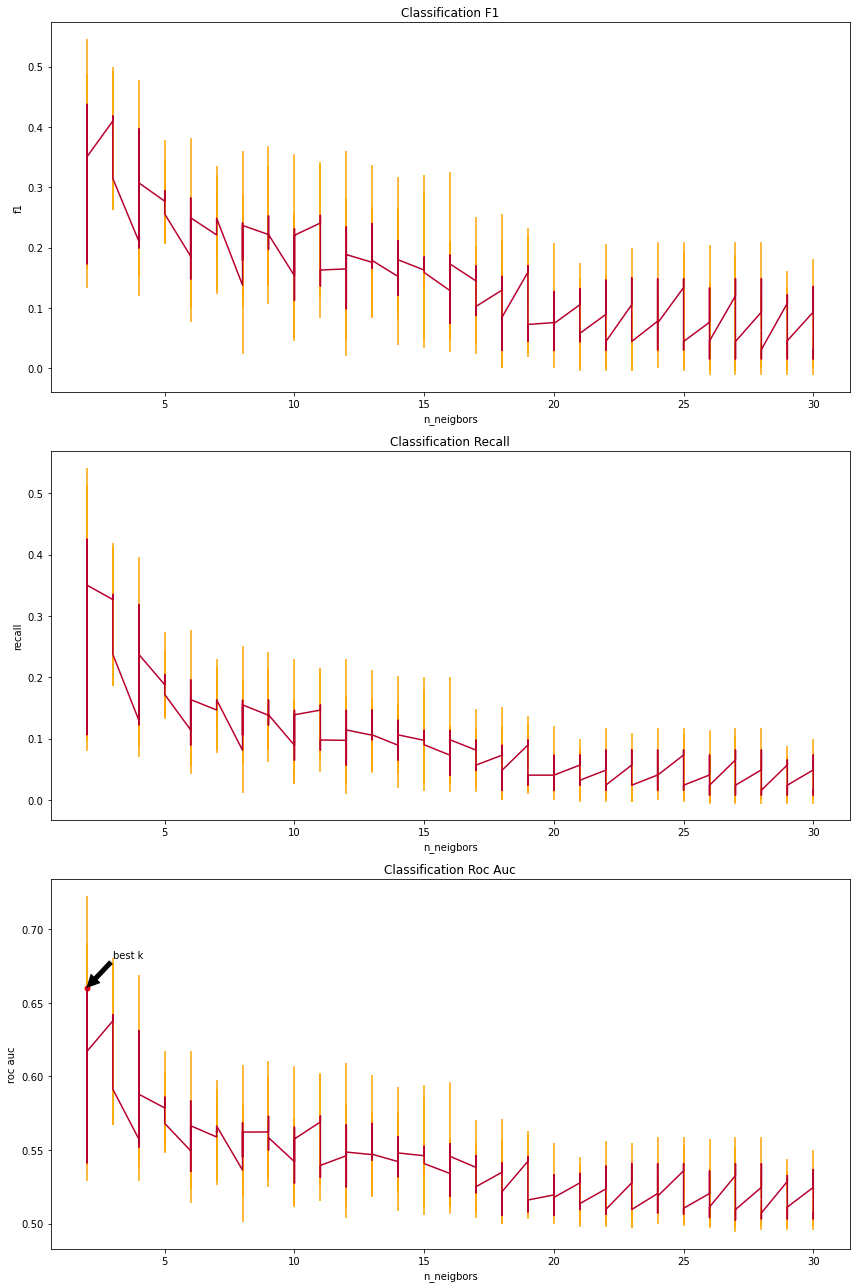



Permutation importances of the training set

OverTime                                           0.045238
NumCompaniesWorked                                 0.003625
DistanceFromHome                                   0.001855
StockOptionLevel                                   0.001604
JobSatisfaction                                    0.001411
RelationshipSatisfaction                           0.000702
EnvironmentSatisfaction                            0.000282
TrainingTimesLastYear                              0.000003
Age                                                0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
OverallSatisfaction                                0.000000
WorkLifeBalance                                    0.000000



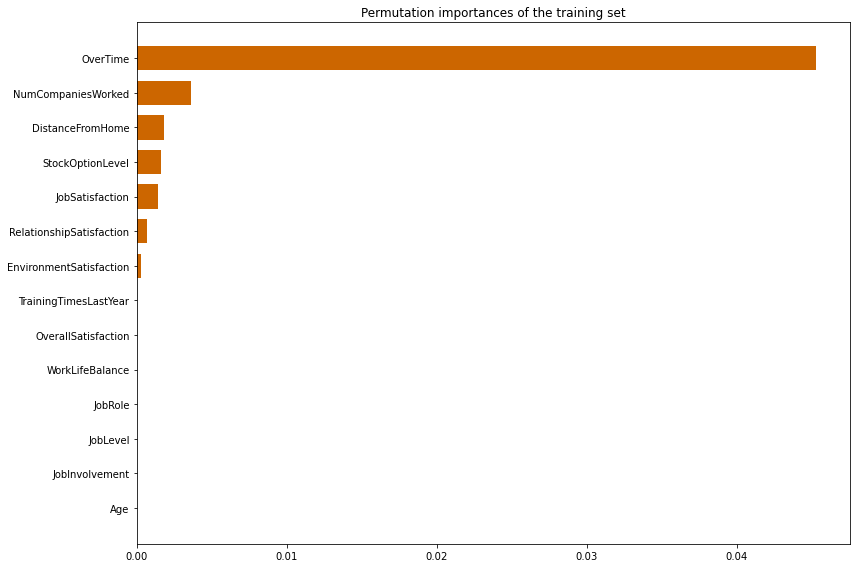



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.069510
OverTime                                           0.049183
JobSatisfaction                                    0.047846
JobLevel                                           0.033760
JobRole                                            0.029441
Age                                                0.023520
OverallSatisfaction                                0.018814
WorkLifeBalance                                    0.017024
RelationshipSatisfaction                           0.009744
JobInvolvement                                     0.009501
NumCompaniesWorked                                 0.005711
TrainingTimesLastYear                              -0.022448
DistanceFromHome                                   -0.024735
EnvironmentSatisfaction                            -0.027276



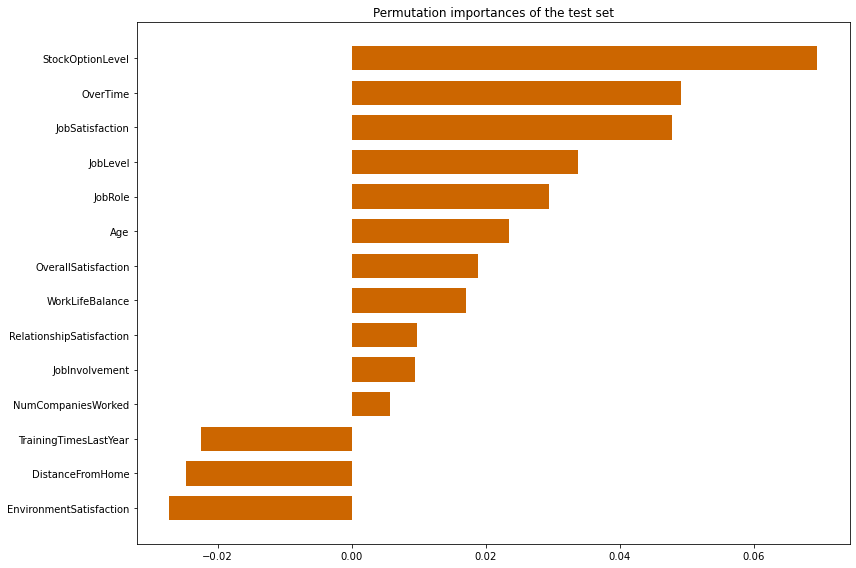



Confusion matrix


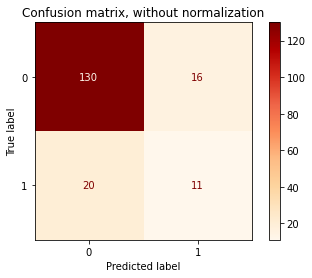

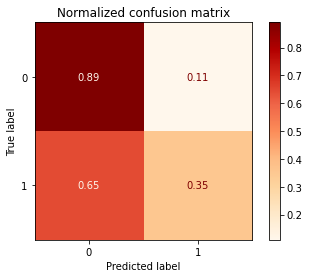


Classification report
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       146
           1       0.41      0.35      0.38        31

    accuracy                           0.80       177
   macro avg       0.64      0.62      0.63       177
weighted avg       0.79      0.80      0.79       177


Metrics

Accuracy 0.7966101694915254
F1-score [0.87837838 0.37931034]
Precision [0.86666667 0.40740741]
Recall [0.89041096 0.35483871]
Roc_auc 0.6226248342907645


Roc curve



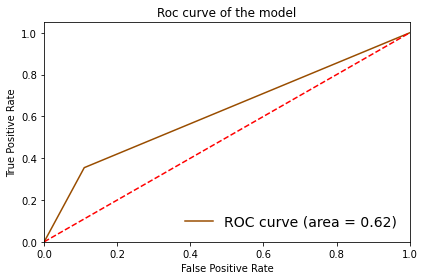


-------------------------------------------------------------------------------------------------------------



In [19]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
max_abs_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MaxAbsScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, max_abs_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = max_abs_dict

<h4>RobustScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6004002429560866
Best parameters: {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=6, p=1, weights='distance')

Best k ('n_neighbors'): 6

Plots of the metrics used by the grid search


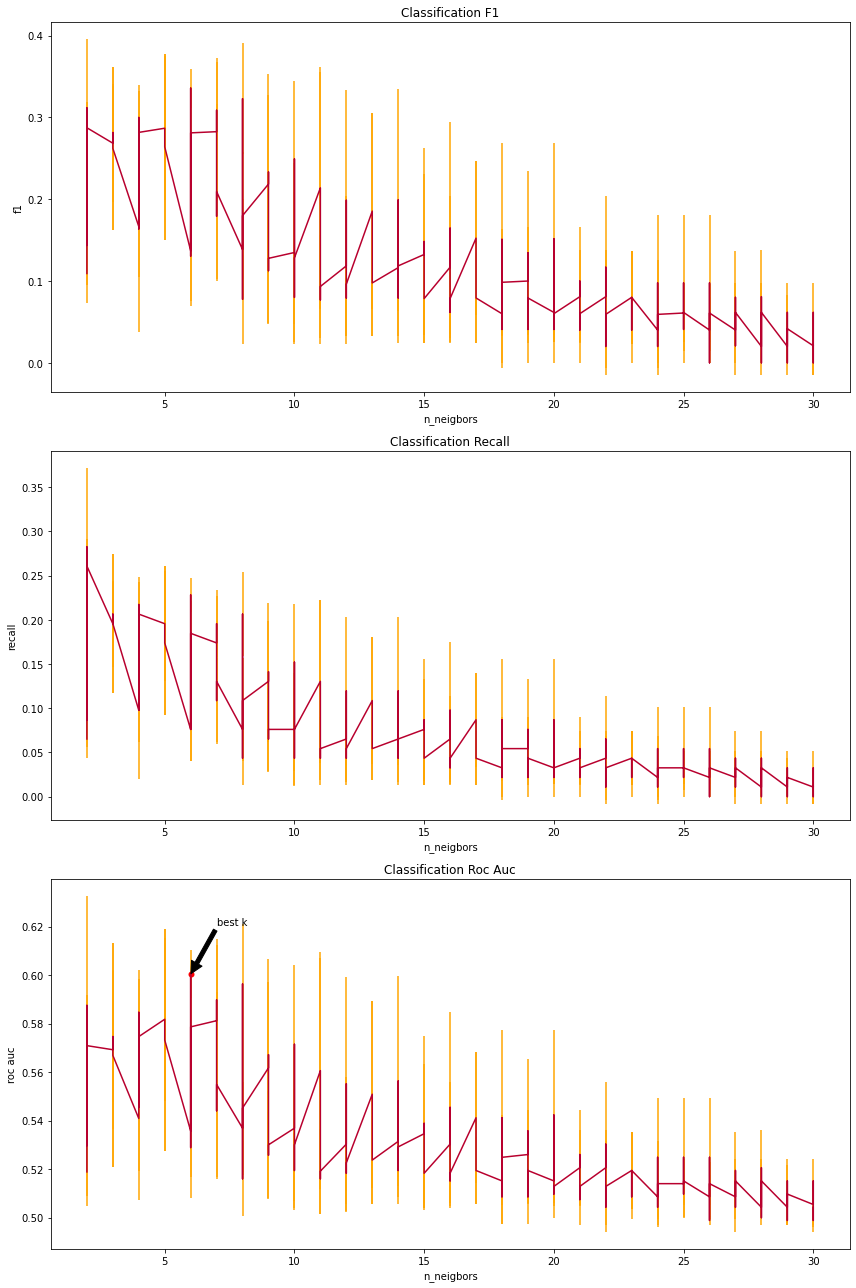



Permutation importances of the training set

StockOptionLevel                                   0.004059
JobLevel                                           0.002365
TrainingTimesLastYear                              0.002191
JobRole                                            0.002174
WorkLifeBalance                                    0.001684
Age                                                0.001455
NumCompaniesWorked                                 0.000905
JobInvolvement                                     0.000803
DistanceFromHome                                   0.000587
OverallSatisfaction                                0.000423
JobSatisfaction                                    0.000271
EnvironmentSatisfaction                            0.000204
RelationshipSatisfaction                           0.000184
OverTime                                           0.000132



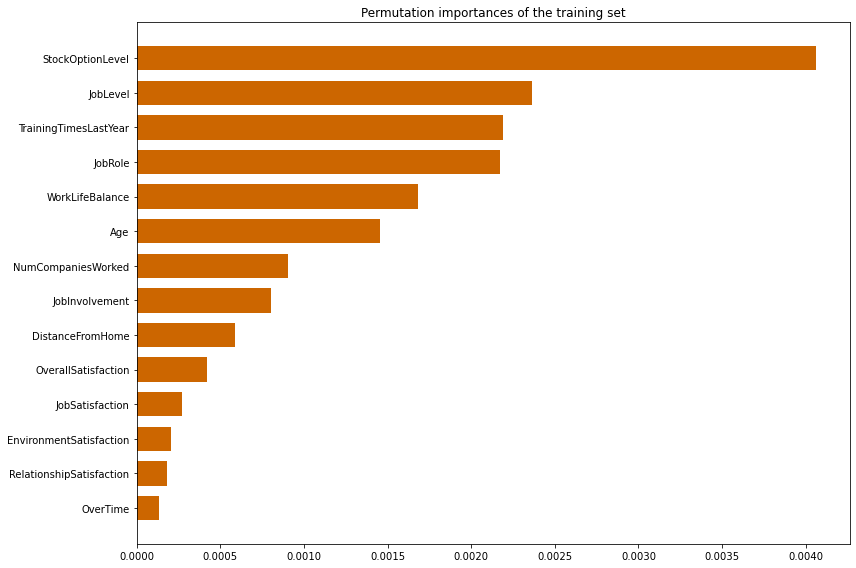



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.036225
OverTime                                           0.032359
JobLevel                                           0.020539
JobRole                                            0.017563
JobSatisfaction                                    0.017437
Age                                                0.010155
OverallSatisfaction                                0.008695
DistanceFromHome                                   0.004456
EnvironmentSatisfaction                            0.004370
NumCompaniesWorked                                 -0.004809
JobInvolvement                                     -0.006087
WorkLifeBalance                                    -0.007973
RelationshipSatisfaction                           -0.011889
TrainingTimesLastYear                              -0.045720



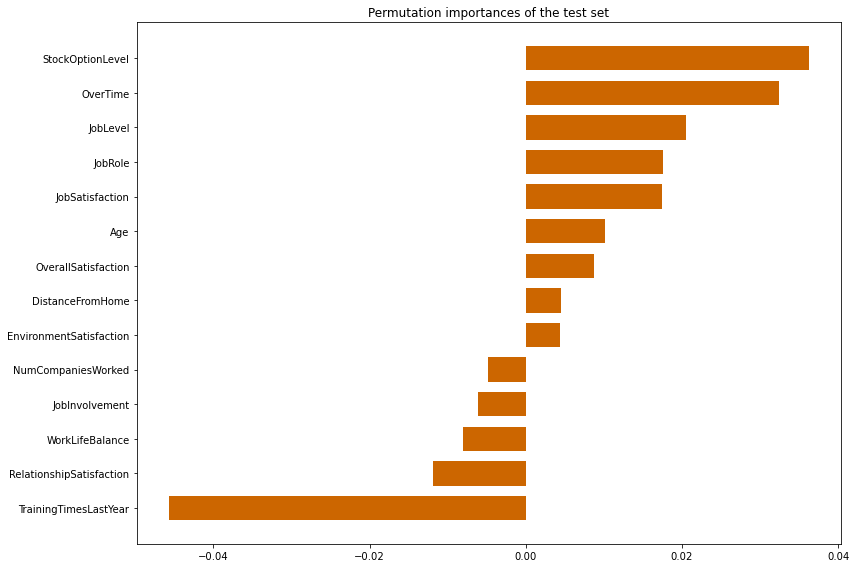



Confusion matrix


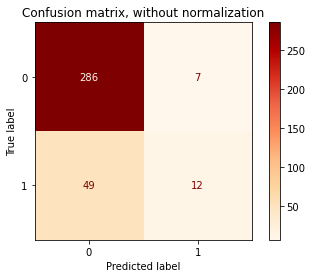

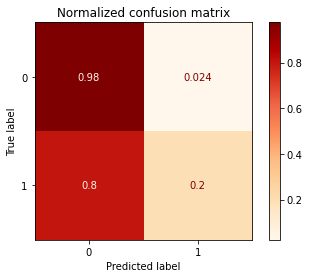


Classification report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       293
           1       0.63      0.20      0.30        61

    accuracy                           0.84       354
   macro avg       0.74      0.59      0.61       354
weighted avg       0.82      0.84      0.81       354


Metrics

Accuracy 0.8418079096045198
F1-score [0.91082803 0.3       ]
Precision [0.85373134 0.63157895]
Recall [0.97610922 0.19672131]
Roc_auc 0.5864152632462374


Roc curve



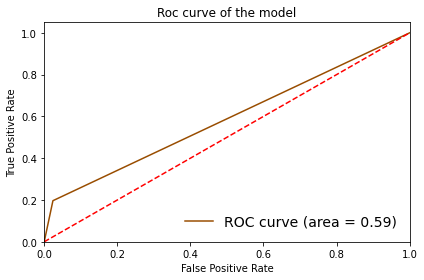


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5917515487597304
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


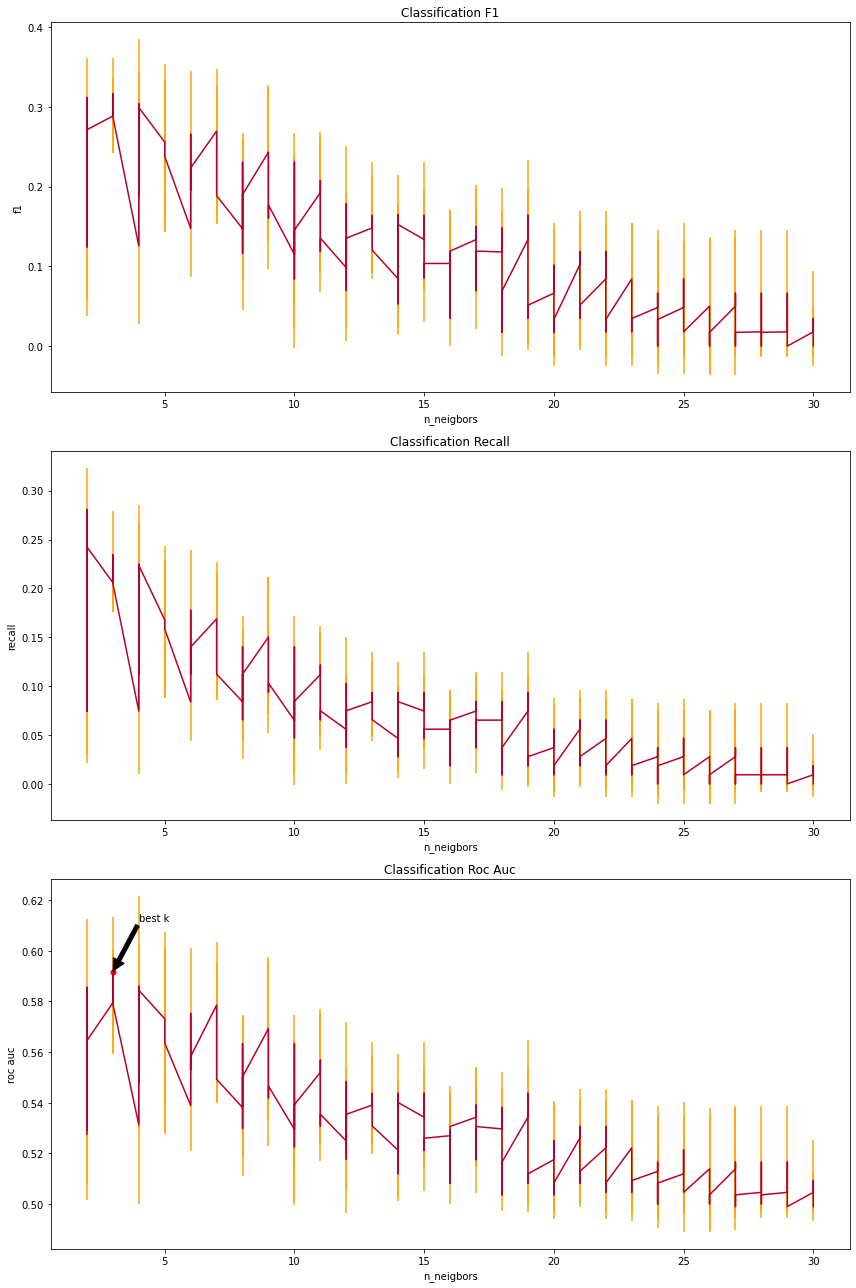



Permutation importances of the training set

StockOptionLevel                                   0.000481
NumCompaniesWorked                                 0.000307
TrainingTimesLastYear                              0.000196
Age                                                0.000177
DistanceFromHome                                   0.000117
JobInvolvement                                     0.000104
WorkLifeBalance                                    0.000084
JobRole                                            0.000077
JobLevel                                           0.000035
RelationshipSatisfaction                           0.000005
OverallSatisfaction                                0.000004
EnvironmentSatisfaction                            0.000000
JobSatisfaction                                    0.000000
OverTime                                           0.000000



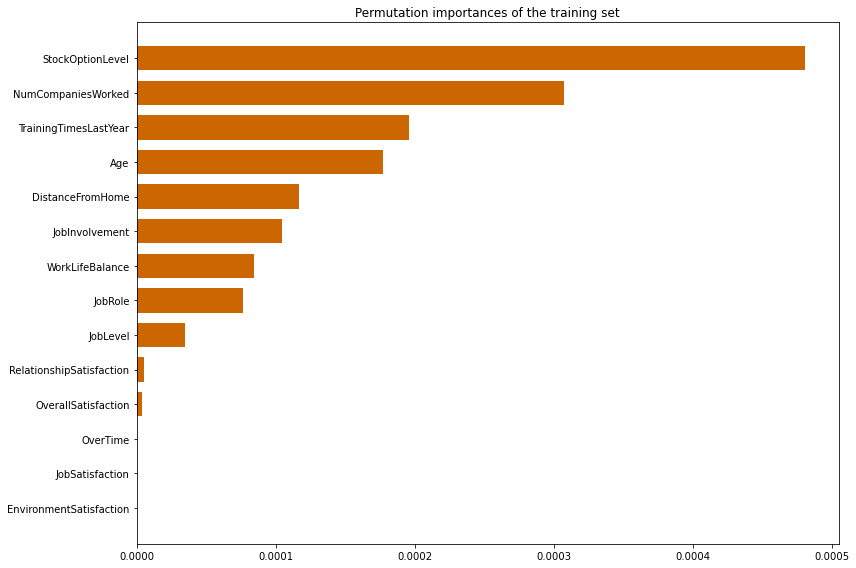



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.054397
OverTime                                           0.019853
JobSatisfaction                                    0.017560
WorkLifeBalance                                    0.015371
NumCompaniesWorked                                 0.014930
OverallSatisfaction                                0.007137
EnvironmentSatisfaction                            0.006844
Age                                                0.006368
JobRole                                            0.003484
DistanceFromHome                                   0.000784
RelationshipSatisfaction                           -0.000740
JobInvolvement                                     -0.006894
JobLevel                                           -0.009505
TrainingTimesLastYear                              -0.023963



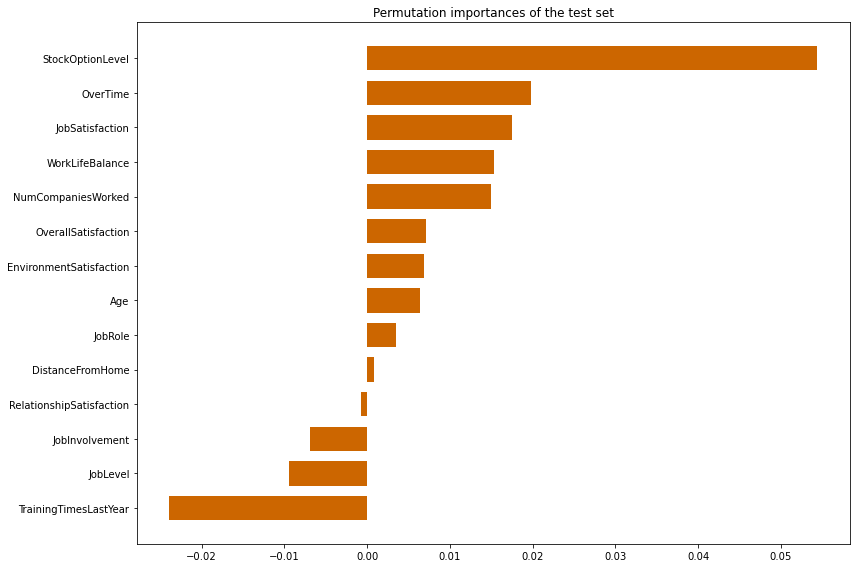



Confusion matrix


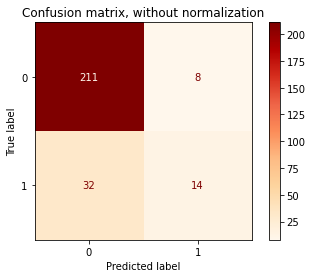

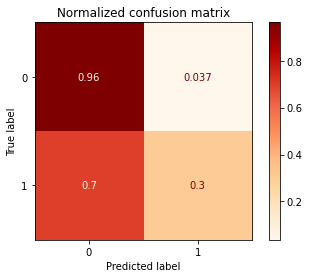


Classification report
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       219
           1       0.64      0.30      0.41        46

    accuracy                           0.85       265
   macro avg       0.75      0.63      0.66       265
weighted avg       0.83      0.85      0.83       265


Metrics

Accuracy 0.8490566037735849
F1-score [0.91341991 0.41176471]
Precision [0.86831276 0.63636364]
Recall [0.96347032 0.30434783]
Roc_auc 0.6339090728608299


Roc curve



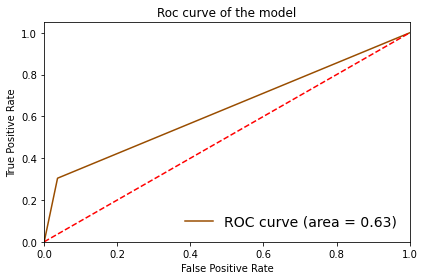


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.625101266755045
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=3, p=1)

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


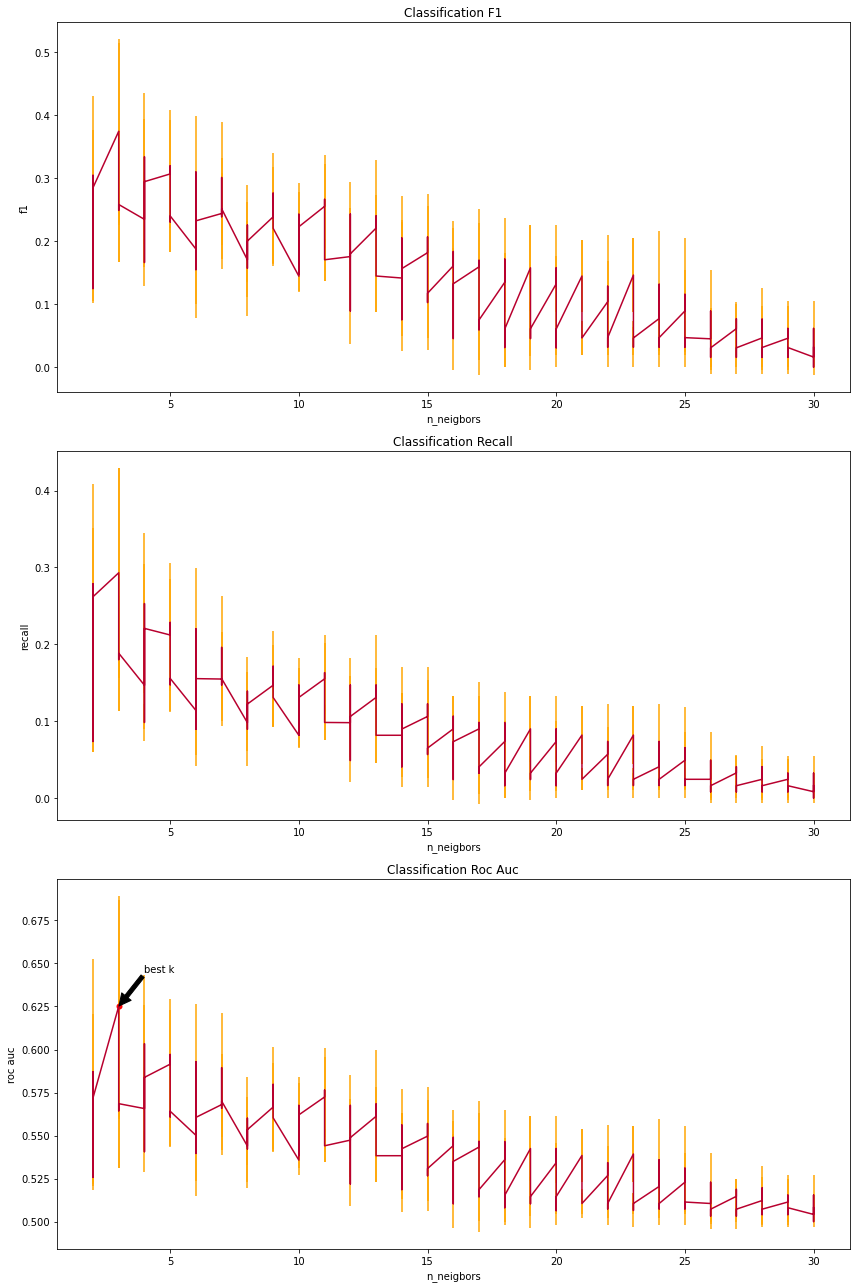



Permutation importances of the training set

JobRole                                            0.011426
StockOptionLevel                                   0.009707
OverTime                                           0.007729
JobSatisfaction                                    0.005602
NumCompaniesWorked                                 0.005597
JobLevel                                           0.005441
RelationshipSatisfaction                           0.003978
Age                                                0.000324
WorkLifeBalance                                    -0.000258
EnvironmentSatisfaction                            -0.000597
OverallSatisfaction                                -0.002452
DistanceFromHome                                   -0.003471
JobInvolvement                                     -0.005682
TrainingTimesLastYear                              -0.011423



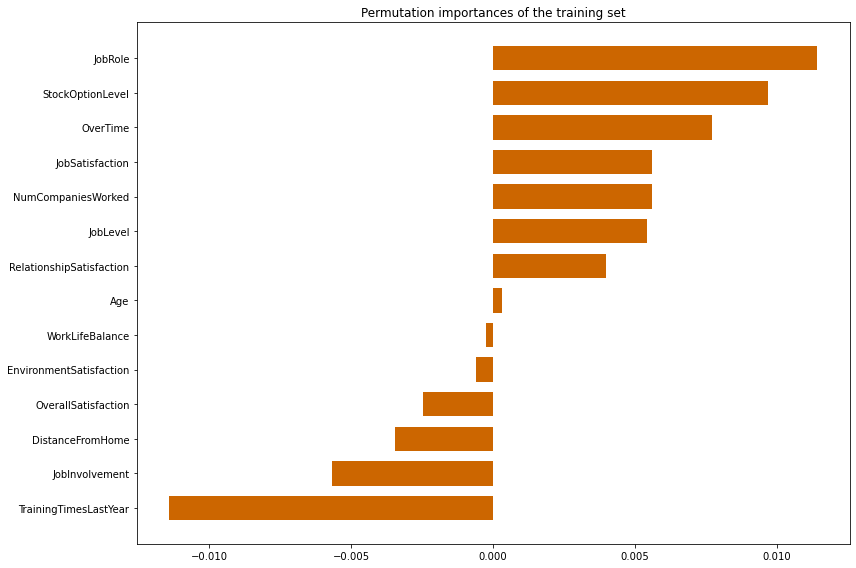



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.077287
JobLevel                                           0.037704
NumCompaniesWorked                                 0.032556
JobRole                                            0.027740
WorkLifeBalance                                    0.027452
JobSatisfaction                                    0.020194
DistanceFromHome                                   0.014958
OverTime                                           0.014152
Age                                                0.012141
JobInvolvement                                     0.008650
EnvironmentSatisfaction                            0.003226
OverallSatisfaction                                0.000917
RelationshipSatisfaction                           -0.006220
TrainingTimesLastYear                              -0.014671



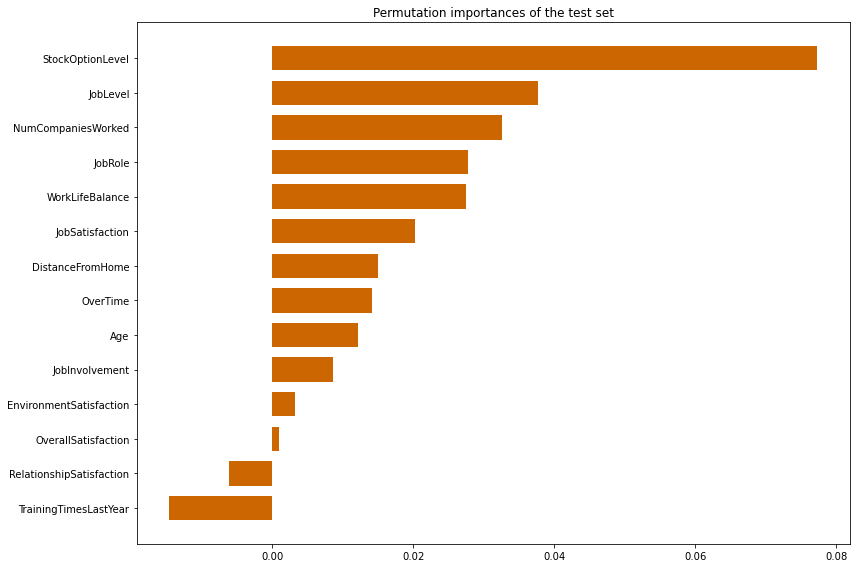



Confusion matrix


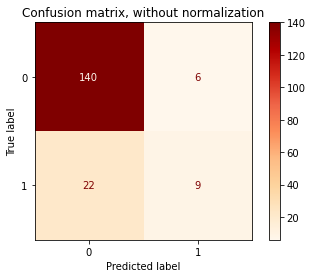

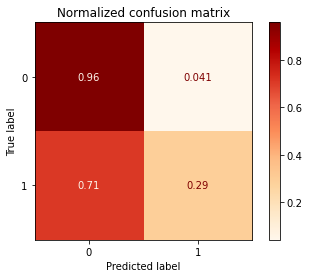


Classification report
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       146
           1       0.60      0.29      0.39        31

    accuracy                           0.84       177
   macro avg       0.73      0.62      0.65       177
weighted avg       0.82      0.84      0.82       177


Metrics

Accuracy 0.8418079096045198
F1-score [0.90909091 0.39130435]
Precision [0.86419753 0.6       ]
Recall [0.95890411 0.29032258]
Roc_auc 0.6246133451171013


Roc curve



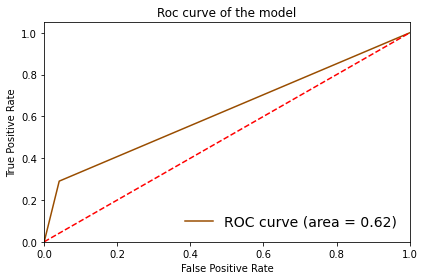


-------------------------------------------------------------------------------------------------------------



In [20]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
robust_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = RobustScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, robust_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = robust_dict

<h4>StandardScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.5832319505384922
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


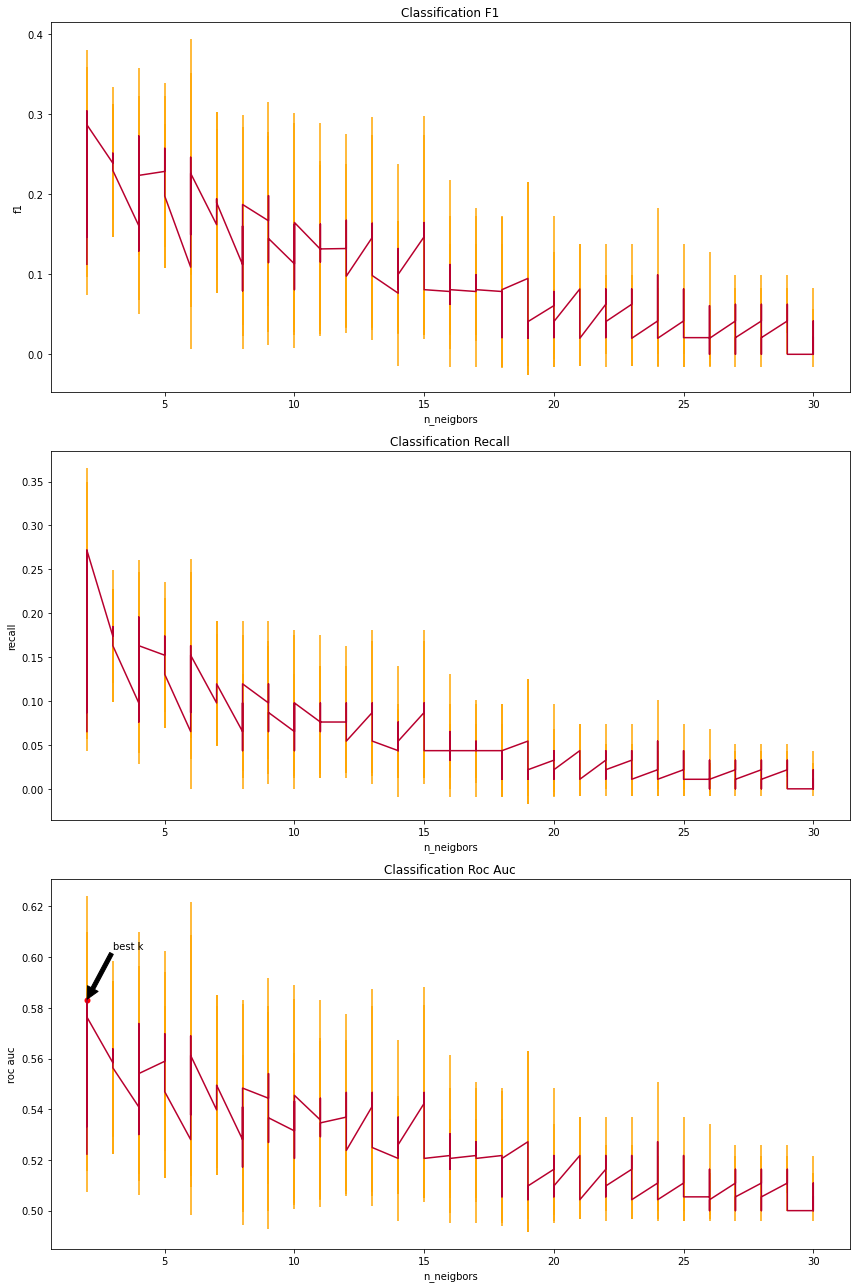



Permutation importances of the training set

OverTime                                           0.000060
JobInvolvement                                     0.000012
StockOptionLevel                                   0.000012
RelationshipSatisfaction                           0.000002
Age                                                0.000000
DistanceFromHome                                   0.000000
EnvironmentSatisfaction                            0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.000000
NumCompaniesWorked                                 0.000000
OverallSatisfaction                                0.000000
TrainingTimesLastYear                              0.000000
WorkLifeBalance                                    0.000000



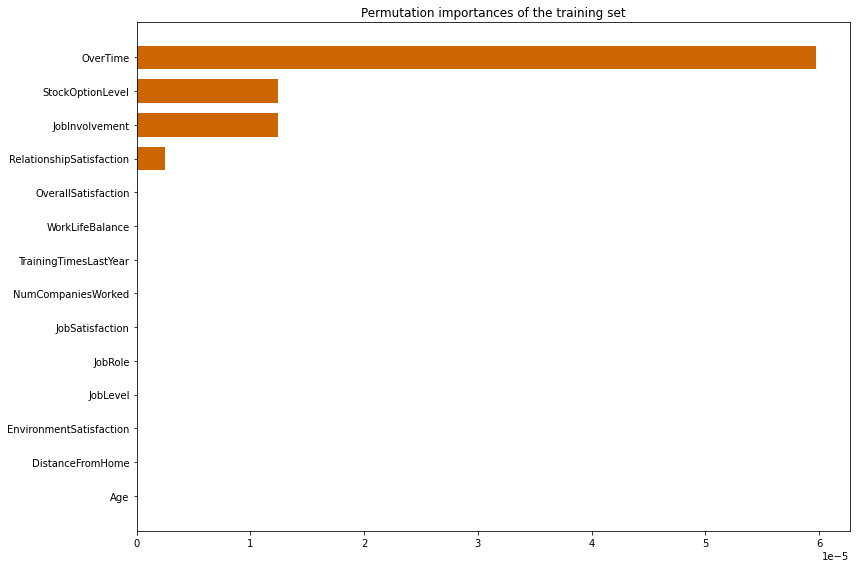



Predictions

Permutation importances of the test set

OverTime                                           0.036997
StockOptionLevel                                   0.031131
JobSatisfaction                                    0.020679
JobRole                                            0.012745
JobLevel                                           0.010552
Age                                                0.003519
RelationshipSatisfaction                           0.002867
JobInvolvement                                     0.000375
OverallSatisfaction                                -0.001298
EnvironmentSatisfaction                            -0.004311
NumCompaniesWorked                                 -0.006683
DistanceFromHome                                   -0.016203
TrainingTimesLastYear                              -0.017994
WorkLifeBalance                                    -0.018080



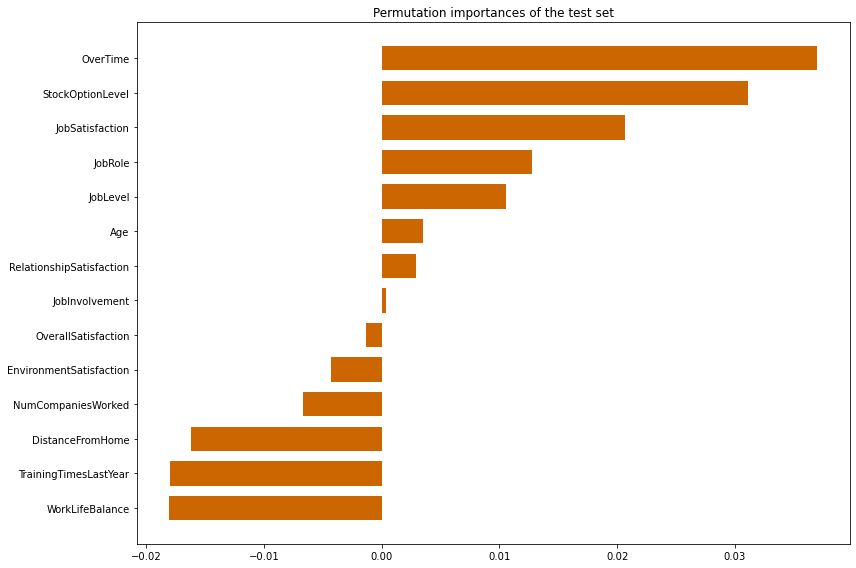



Confusion matrix


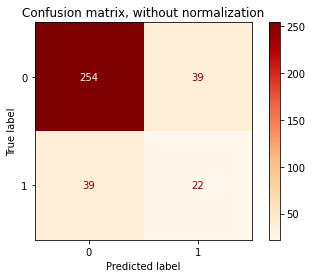

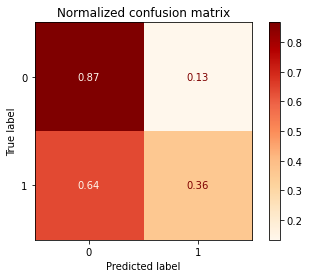


Classification report
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       293
           1       0.36      0.36      0.36        61

    accuracy                           0.78       354
   macro avg       0.61      0.61      0.61       354
weighted avg       0.78      0.78      0.78       354


Metrics

Accuracy 0.7796610169491526
F1-score [0.8668942  0.36065574]
Precision [0.8668942  0.36065574]
Recall [0.8668942  0.36065574]
Roc_auc 0.6137749678285682


Roc curve



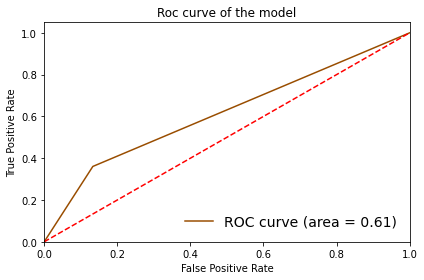


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5971098157752317
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


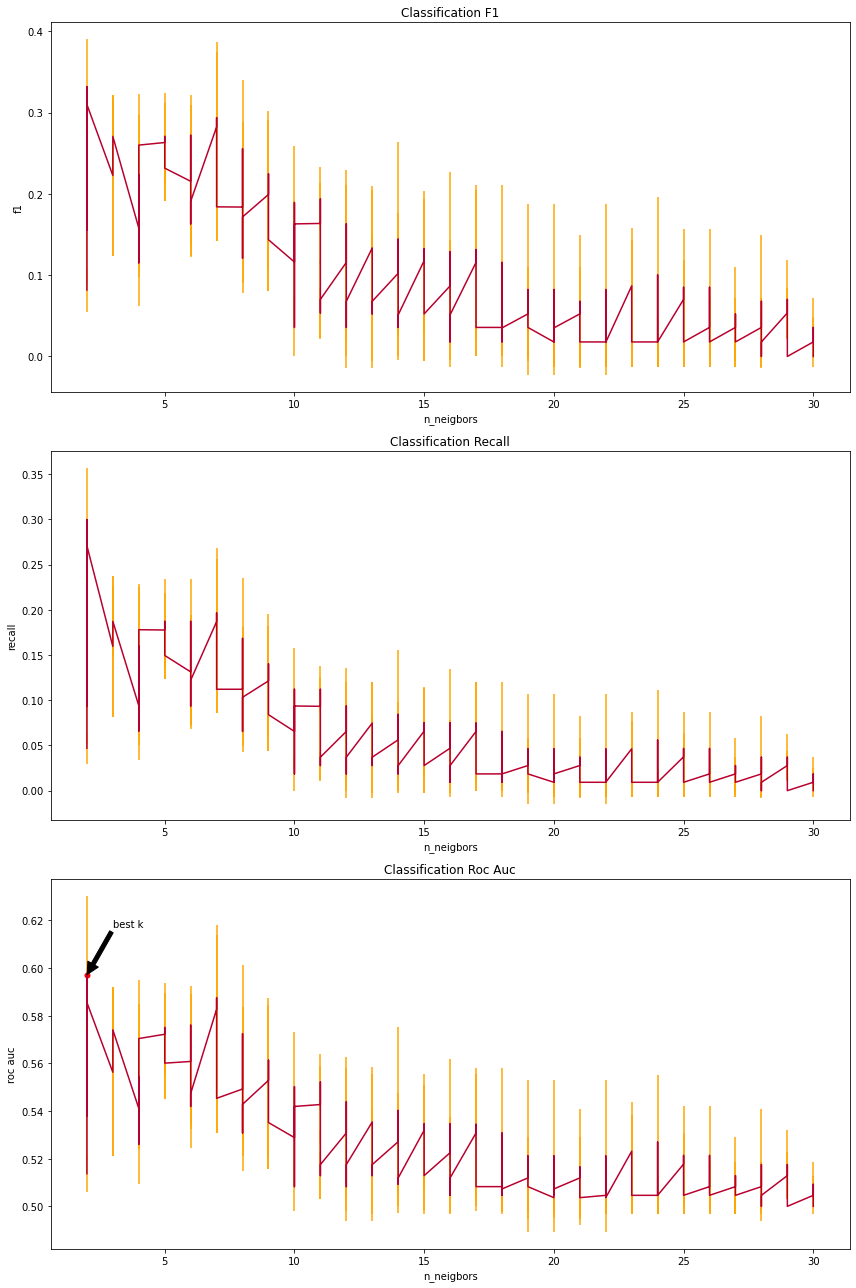



Permutation importances of the training set

OverTime                                           0.000048
StockOptionLevel                                   0.000022
JobInvolvement                                     0.000005
RelationshipSatisfaction                           0.000005
NumCompaniesWorked                                 0.000002
Age                                                0.000000
DistanceFromHome                                   0.000000
EnvironmentSatisfaction                            0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.000000
OverallSatisfaction                                0.000000
TrainingTimesLastYear                              0.000000
WorkLifeBalance                                    0.000000



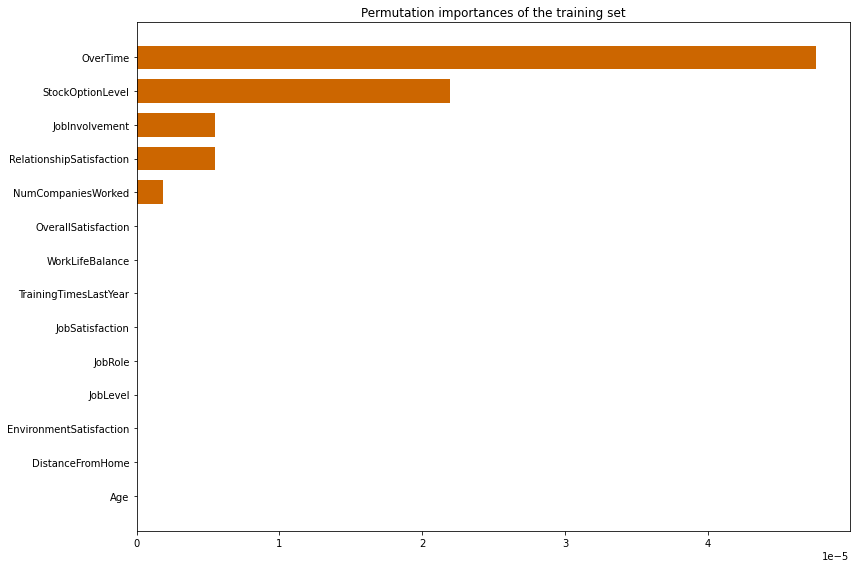



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.042848
OverTime                                           0.042560
JobSatisfaction                                    0.030038
OverallSatisfaction                                0.021724
NumCompaniesWorked                                 0.011952
Age                                                0.009510
RelationshipSatisfaction                           0.007862
JobLevel                                           0.006686
JobRole                                            0.003856
EnvironmentSatisfaction                            -0.005097
JobInvolvement                                     -0.006115
WorkLifeBalance                                    -0.009301
TrainingTimesLastYear                              -0.025675
DistanceFromHome                                   -0.033492



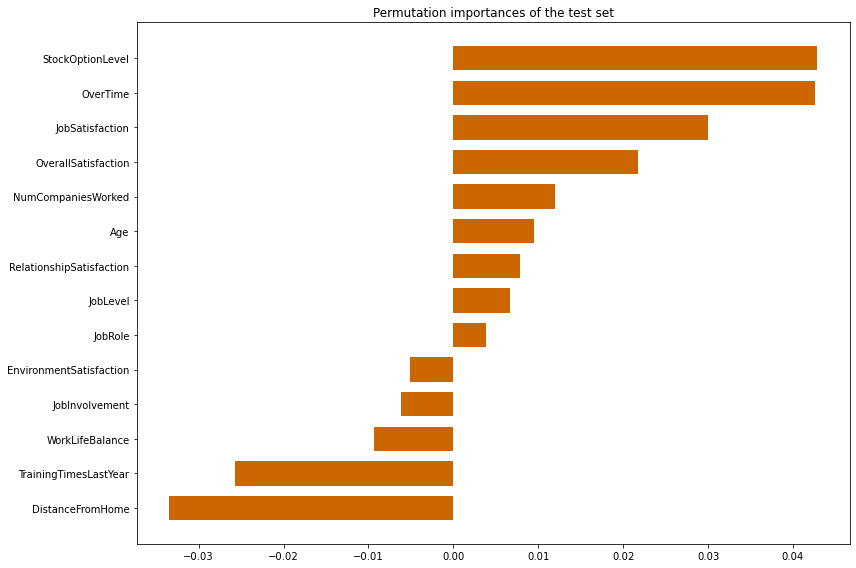



Confusion matrix


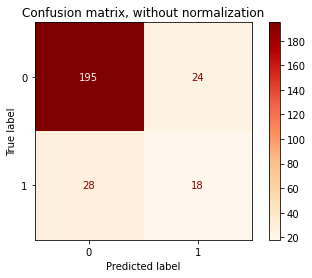

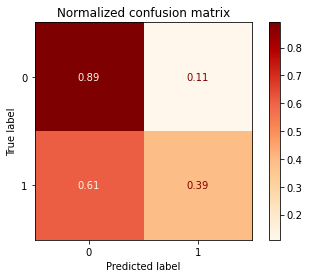


Classification report
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       219
           1       0.43      0.39      0.41        46

    accuracy                           0.80       265
   macro avg       0.65      0.64      0.65       265
weighted avg       0.80      0.80      0.80       265


Metrics

Accuracy 0.8037735849056604
F1-score [0.88235294 0.40909091]
Precision [0.87443946 0.42857143]
Recall [0.89041096 0.39130435]
Roc_auc 0.6408576533650983


Roc curve



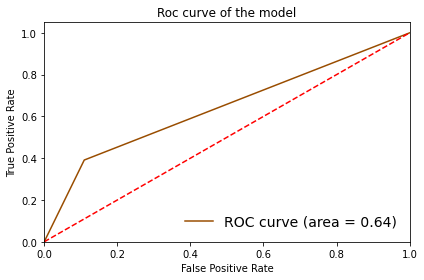


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6448666961260863
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


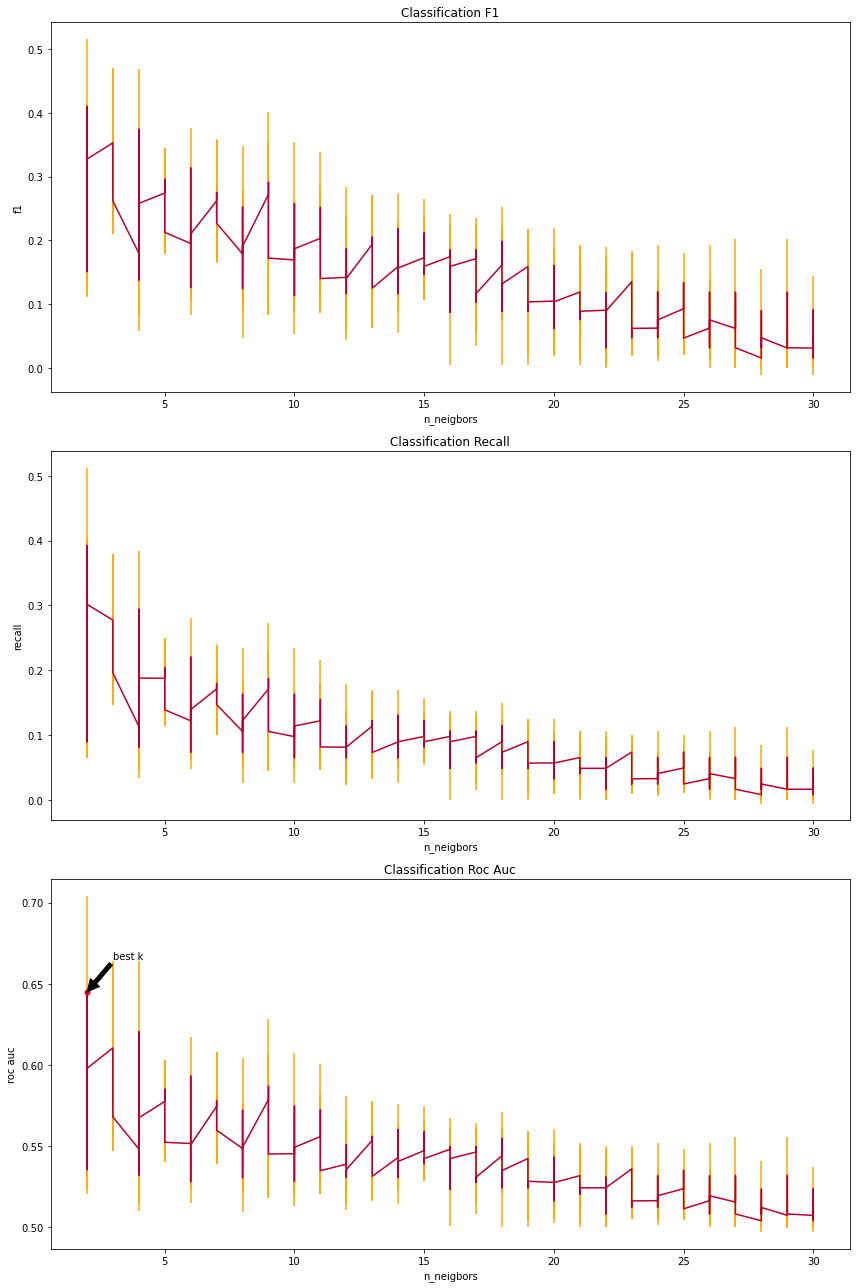



Permutation importances of the training set

OverTime                                           0.000124
StockOptionLevel                                   0.000017
EnvironmentSatisfaction                            0.000008
JobInvolvement                                     0.000008
Age                                                0.000004
NumCompaniesWorked                                 0.000003
RelationshipSatisfaction                           0.000001
TrainingTimesLastYear                              0.000001
DistanceFromHome                                   0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.000000
OverallSatisfaction                                0.000000
WorkLifeBalance                                    0.000000



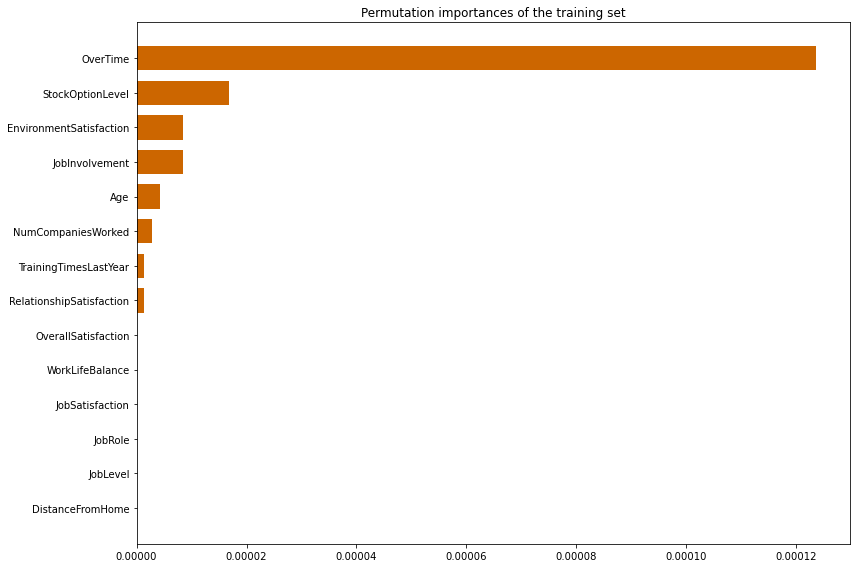



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.078878
OverTime                                           0.077132
JobSatisfaction                                    0.038621
WorkLifeBalance                                    0.029529
OverallSatisfaction                                0.028624
JobRole                                            0.025817
Age                                                0.020658
RelationshipSatisfaction                           0.011600
JobLevel                                           0.011357
NumCompaniesWorked                                 0.010904
EnvironmentSatisfaction                            0.009677
JobInvolvement                                     0.004010
TrainingTimesLastYear                              -0.003822
DistanceFromHome                                   -0.025994



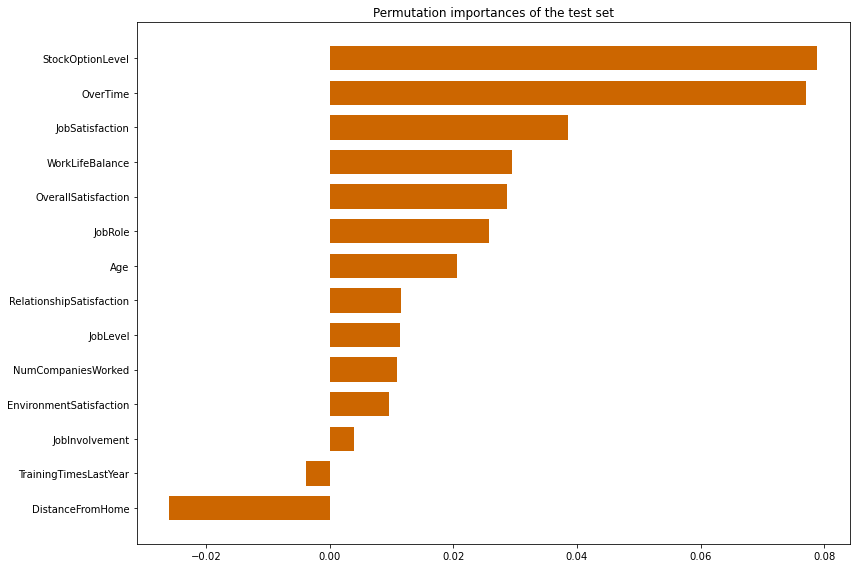



Confusion matrix


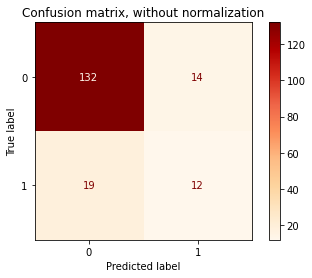

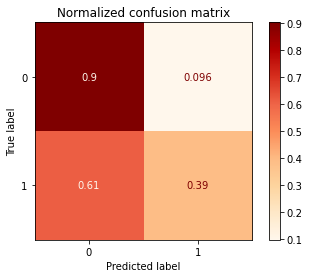


Classification report
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       146
           1       0.46      0.39      0.42        31

    accuracy                           0.81       177
   macro avg       0.67      0.65      0.65       177
weighted avg       0.80      0.81      0.81       177


Metrics

Accuracy 0.8135593220338984
F1-score [0.88888889 0.42105263]
Precision [0.87417219 0.46153846]
Recall [0.90410959 0.38709677]
Roc_auc 0.6456031816173222


Roc curve



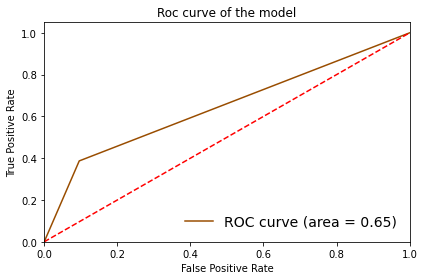


-------------------------------------------------------------------------------------------------------------



In [21]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
standard_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = StandardScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, standard_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = standard_dict

In [22]:
scaler_dict

{'MinMaxScaler': {'60-40': {'fpr': [0.0, 0.051194539249146756, 1.0],
   'tpr': [0.0, 0.22950819672131148, 1.0],
   'roc': 0.5891568287360823},
  '70-30': {'fpr': [0.0, 0.0319634703196347, 1.0],
   'tpr': [0.0, 0.2391304347826087, 1.0],
   'roc': 0.603583482231487},
  '80-20': {'fpr': [0.0, 0.1232876712328767, 1.0],
   'tpr': [0.0, 0.3225806451612903, 1.0],
   'roc': 0.5996464869642067}},
 'MaxAbsScaler': {'60-40': {'fpr': [0.0, 0.051194539249146756, 1.0],
   'tpr': [0.0, 0.26229508196721313, 1.0],
   'roc': 0.6055502713590333},
  '70-30': {'fpr': [0.0, 0.1278538812785388, 1.0],
   'tpr': [0.0, 0.43478260869565216, 1.0],
   'roc': 0.6534643637085567},
  '80-20': {'fpr': [0.0, 0.1095890410958904, 1.0],
   'tpr': [0.0, 0.3548387096774194, 1.0],
   'roc': 0.6226248342907645}},
 'RobustScaler': {'60-40': {'fpr': [0.0, 0.023890784982935155, 1.0],
   'tpr': [0.0, 0.19672131147540983, 1.0],
   'roc': 0.5864152632462374},
  '70-30': {'fpr': [0.0, 0.0365296803652968, 1.0],
   'tpr': [0.0, 0.3043

In [29]:
temporal_info = {}

In [30]:
model_name = '15f numerical-encoded no discretized'

In [31]:
temporal_info[model_name] = scaler_dict['MaxAbsScaler']['70-30']
temporal_info

{'15f numerical-encoded no discretized': {'fpr': [0.0,
   0.1278538812785388,
   1.0],
  'tpr': [0.0, 0.43478260869565216, 1.0],
  'roc': 0.6534643637085567}}

In [32]:
with open('temporal_info.json', "r+") as json_file: 
    data = json.load(json_file)
    data['no_discr']['validation'].update(temporal_info)

    
with open('temporal_info.json','w') as f: 
    json.dump(data, f, indent=4)